设定文件的D和W

In [101]:
d1,d2=2500,2500
w1,w2=40,40


window_size = 40  # 窗口大小
poly_order = 8    # 多项式阶数

# 设置Kalman滤波器的测量噪声和过程噪声
measurement_noise = 20
process_noise = 0.1

读取文件的必要操作

In [102]:
from ctypes import windll
#from sympy.physics.units.definitions.unit_definitions import ms
windll.shcore.SetProcessDpiAwareness(1)
import tkinter as tk
import pickle
import sys


#由你的电脑的屏幕大小来决定

def get_screen_size():
    root = tk.Tk()
    screen_width = root.winfo_screenwidth()
    screen_height = root.winfo_screenheight()
    root.destroy()
    return screen_width, screen_height
screen_wide,screen_high=get_screen_size()

#print(screen_wide,screen_high  )

def read_data(d1,d2,w1,w2):
    '''
    通过D,和W的大小来区分和读取数据，并返回四个数据结果。
    '''
    name=sys.path[0]+'\data\\'+'D='+str(d1)+'-'+str(d2)+'_W='+str(w1)+'-'+str(w2)+".bin"

    with open(name,'rb') as file:
        move_datas=pickle.load(file)
    
    return move_datas

mouse_move=read_data(d1,d2,w1,w2)

mouse_move的结构是[[t,x,y],[],~~~,[]]

In [103]:
import numpy as np
for i in range(len(mouse_move)):
    print(np.shape(mouse_move[i]))
print(mouse_move[0][0])

(368924, 3)
(450518, 3)
(368683, 3)
(381925, 3)
(343209, 3)
(358564, 3)
(425609, 3)
(291471, 3)
(426497, 3)
(374789, 3)
(336550, 3)
(364134, 3)
(338063, 3)
(292662, 3)
(309320, 3)
(359312, 3)
(1690955587.9499943, 38.0, 797.0)


对数据进行清洗，删除重复点

In [104]:
def clean(mouse_move):
    new1=[]
    for i in range(len(mouse_move)):
        new2=[]
        t=-1
        x=-1
        y=-1
        for j in range(len(mouse_move[i])):
            
            if t==mouse_move[i][j][0] and x==mouse_move[i][j][1] and y==mouse_move[i][j][2]:
                t=mouse_move[i][j][0]
                x=mouse_move[i][j][1]
                y=mouse_move[i][j][2]
                continue
            else:
                t=mouse_move[i][j][0]
                x=mouse_move[i][j][1]
                y=mouse_move[i][j][2]
                new2.append(mouse_move[i][j])
        new1.append(new2)
    return new1

def average(mouse_move):
    new=[]
    for i in range(len(mouse_move)):
        new1=[]
        for j in range(len(mouse_move[i])-1):
            t=mouse_move[i][j][0]
            if mouse_move[i][j][0]==mouse_move[i][j+1][0]:
                r=1
                for k in range(j+1,len(mouse_move[i])-1):
                    if mouse_move[i][j][0]==mouse_move[i][k][0]:
                        r+=1
                        #print(k)
                #print('对于',mouse_move[i][j][0],'有',r,'个连续重复值')
                
                t0=mouse_move[i][j-1][0]
                t1=mouse_move[i][j+r][0]
                m=(t1-t0)/(r+1)
                t=t0+m*2
                
            new1.append([t,mouse_move[i][j][1],mouse_move[i][j][2]])
        new.append(new1)    
    
    for i in range(len(new)):
        for j in range(len(new[i])-1):
            if new[i][j][0]==new[i][j+1][0]:
                print('存在前后相同点：',i,j)
    
    return new


mouse_move=clean(mouse_move)
#由于平均后的效果并不好，所以不采用
#mouse_move=average(mouse_move)

计算平均时间

In [105]:
import numpy as np
t=[]
for i in range(len(mouse_move)):
    #print(np.shape(mouse_move[i]))
    #print(mouse_move[i][-1][0]-mouse_move[i][0][0])
    t.append(mouse_move[i][-1][0]-mouse_move[i][0][0])

print('平均时间为',np.mean(t))

平均时间为 1.1442638337612152


对X与Y使用Savitzky-Golay滤波器平滑数据

In [106]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter



T_all=[]
X_all=[]
Y_all=[]
for k in range(len(mouse_move)):
    T=[]
    X=[]
    Y=[]
    for i in range(len(mouse_move[k])):
        #print(mouse_move[0][i])
        T.append(mouse_move[k][i][0]-mouse_move[k][0][0])
        X.append(mouse_move[k][i][1])
        Y.append(mouse_move[k][i][2])   

    # 使用Savitzky-Golay滤波器平滑数据
    
    X_smoothed = savgol_filter(X, window_size, poly_order)
    Y_smoothed = savgol_filter(Y, window_size, poly_order)
    T_all.append(T)
    X_all.append(X_smoothed)
    Y_all.append(Y_smoothed)


计算总距离S

In [107]:
import numpy as np

S_all=[]

for i in range(len(T_all)):
    s=0
    S=[0,]#点在轨迹上的位置
    for j in range(1,len(T_all[i])):
        s+=np.sqrt((X_all[i][j]-X_all[i][j-1])**2+(Y_all[i][j]-Y_all[i][j-1])**2)
        S.append(s)
    S_all.append(S)

对S进行平滑滤波处理

In [108]:
import random
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter

def apply_kalman_filter(trajectory, measurement_noise, process_noise):
    # 初始化Kalman滤波器
    kf = KalmanFilter(dim_x=2, dim_z=1)
    
    # 设置状态转移矩阵F，这里假设每一步状态都是从上一步演化而来
    kf.F = np.array([[1., 1.],
                     [0., 1.]])
    
    # 设置测量矩阵H，这里是一个1x2的矩阵，表示从状态空间到测量空间的映射
    kf.H = np.array([[1., 0.]])
    
    # 设置测量噪声矩阵R，这里假设测量噪声是高斯分布
    kf.R = measurement_noise**2
    
    # 设置过程噪声矩阵Q，这里假设过程噪声也是高斯分布
    kf.Q = np.array([[process_noise**2, 0.],
                     [0., process_noise**2]])
    
    # 初始化状态向量x和协方差矩阵P
    kf.x = np.array([trajectory[0][0], 0.])  # 初始位置和速度都设为0
    kf.P = np.eye(2)  # 初始协方差矩阵设为单位矩阵
    
    # 用Kalman滤波器对轨迹数据进行处理
    smoothed_trajectory = [kf.x[0]]  # 用于存储平滑后的轨迹
    for measurement in trajectory[1:]:
        kf.predict()  # 预测下一时刻状态
        kf.update(measurement[1])  # 更新状态，这里只有Y坐标是测量值，X坐标由状态转移矩阵预测得到
        smoothed_trajectory.append(kf.x[0])
    
    return smoothed_trajectory

S_all_smoothed=[]
for j in range(len(T_all)):
    trajectory_with_noise=[]
    for i in range(len(T_all[j])):
        trajectory_with_noise.append((T_all[j][i],S_all[j][i]))
    

    # 使用Kalman滤波器对轨迹数据进行降噪处理
    S_smoothed = apply_kalman_filter(trajectory_with_noise, measurement_noise, process_noise)
    #强制单调递增
    for i in range(len(S_smoothed)-1):
        if S_smoothed[i+1]<S_smoothed[i]:
            S_smoothed[i+1]=S_smoothed[i]

    S_all_smoothed.append(S_smoothed)


由S求V

C:\Users\liuyu\AppData\Local\Temp\ipykernel_14760\3861501135.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  velocities.append((distance[i+1]-distance[i]) / (time[i+1] - time[i]))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


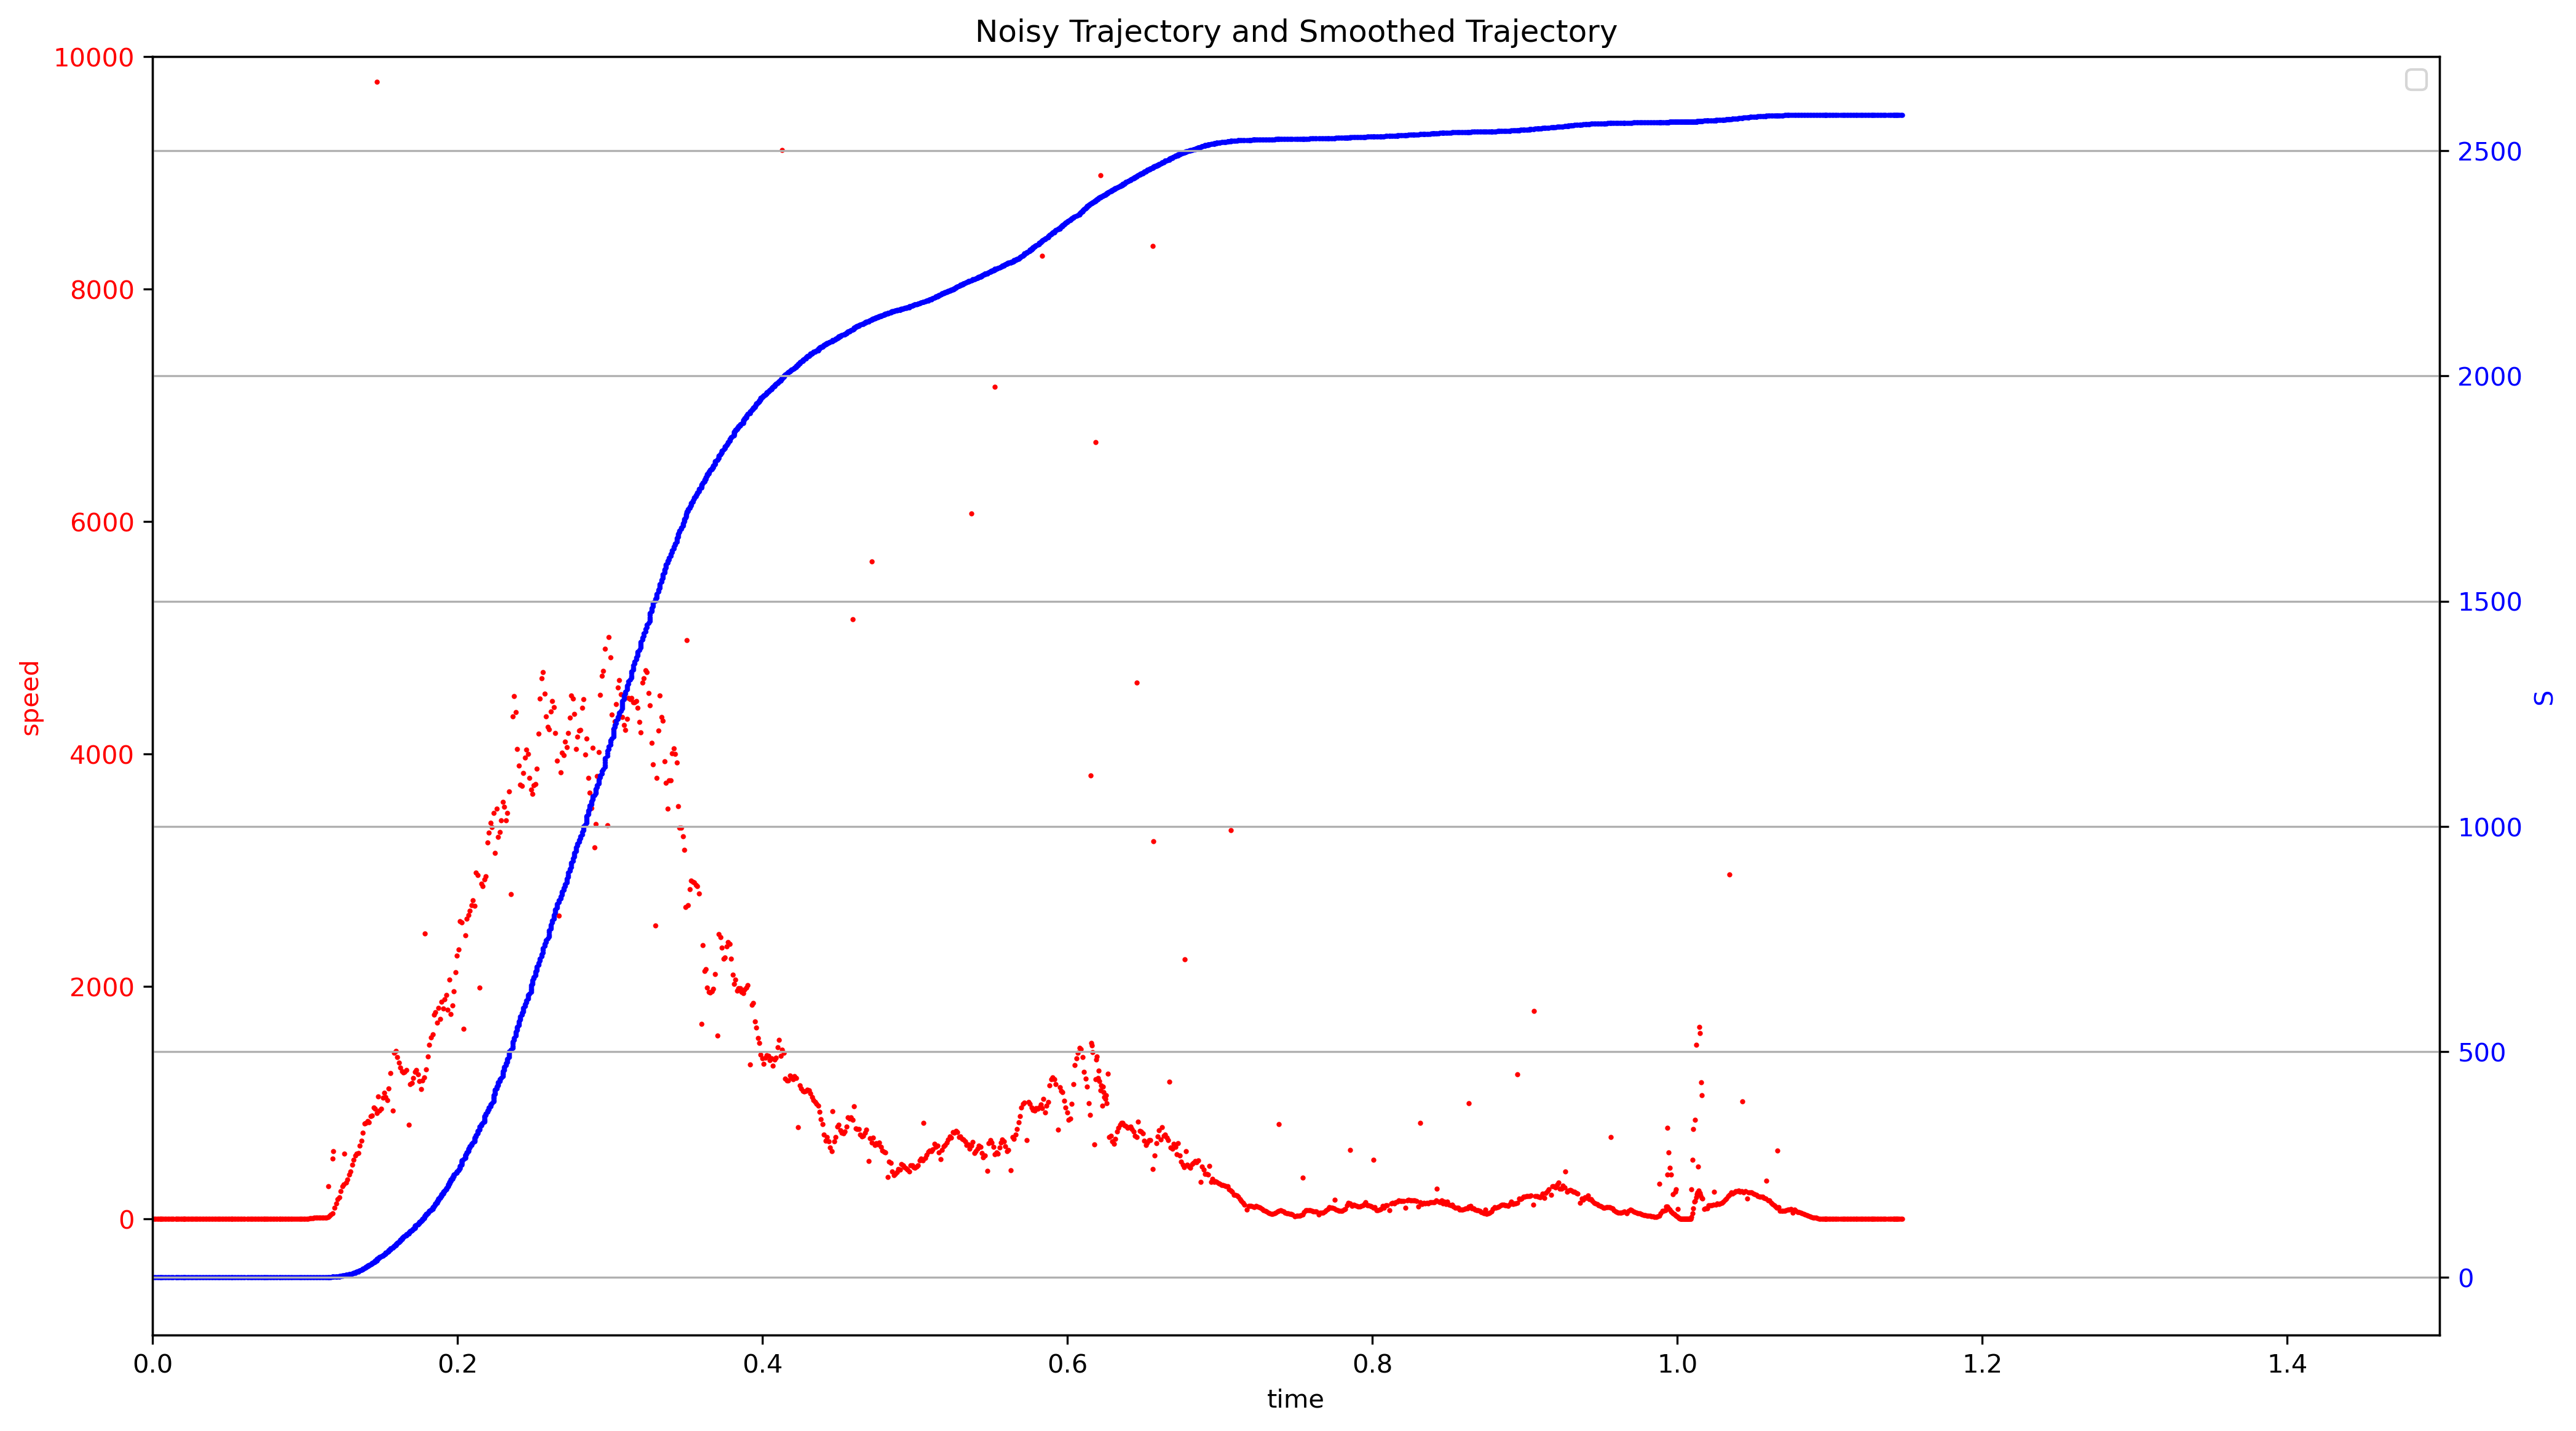

C:\Users\liuyu\AppData\Local\Temp\ipykernel_14760\3861501135.py:12: RuntimeWarning: invalid value encountered in double_scalars
  velocities.append((distance[i+1]-distance[i]) / (time[i+1] - time[i]))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


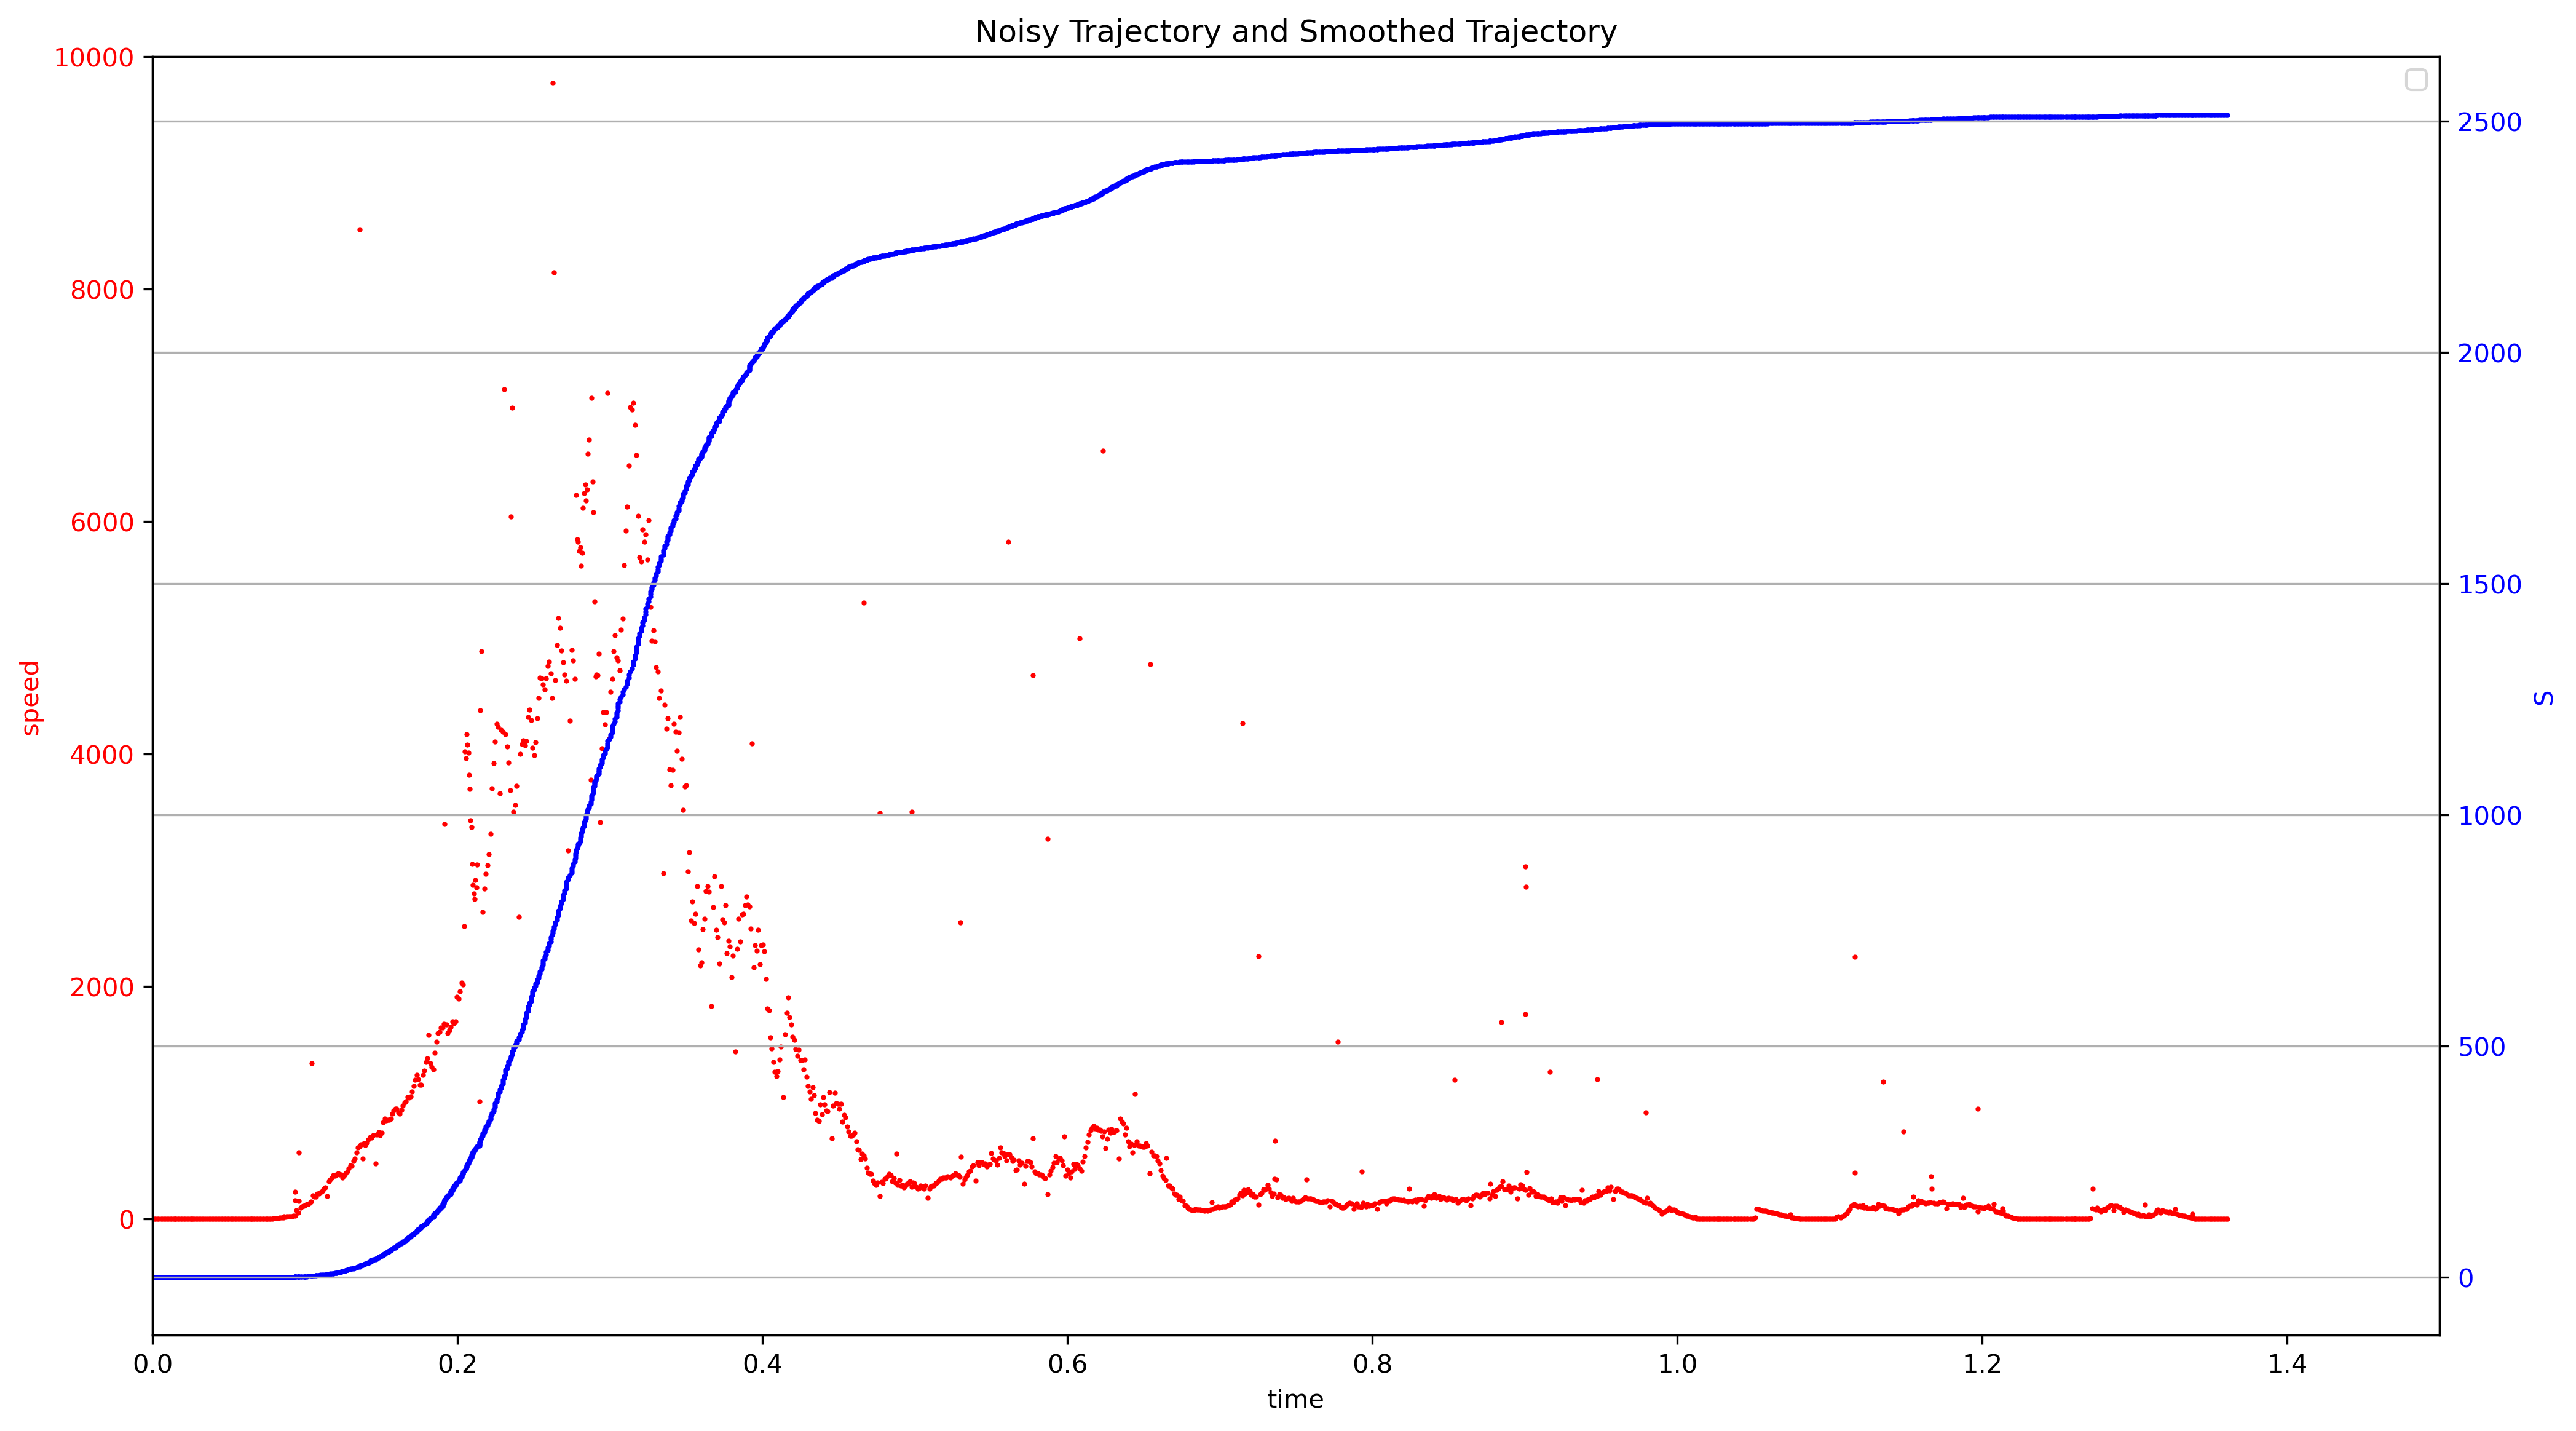

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


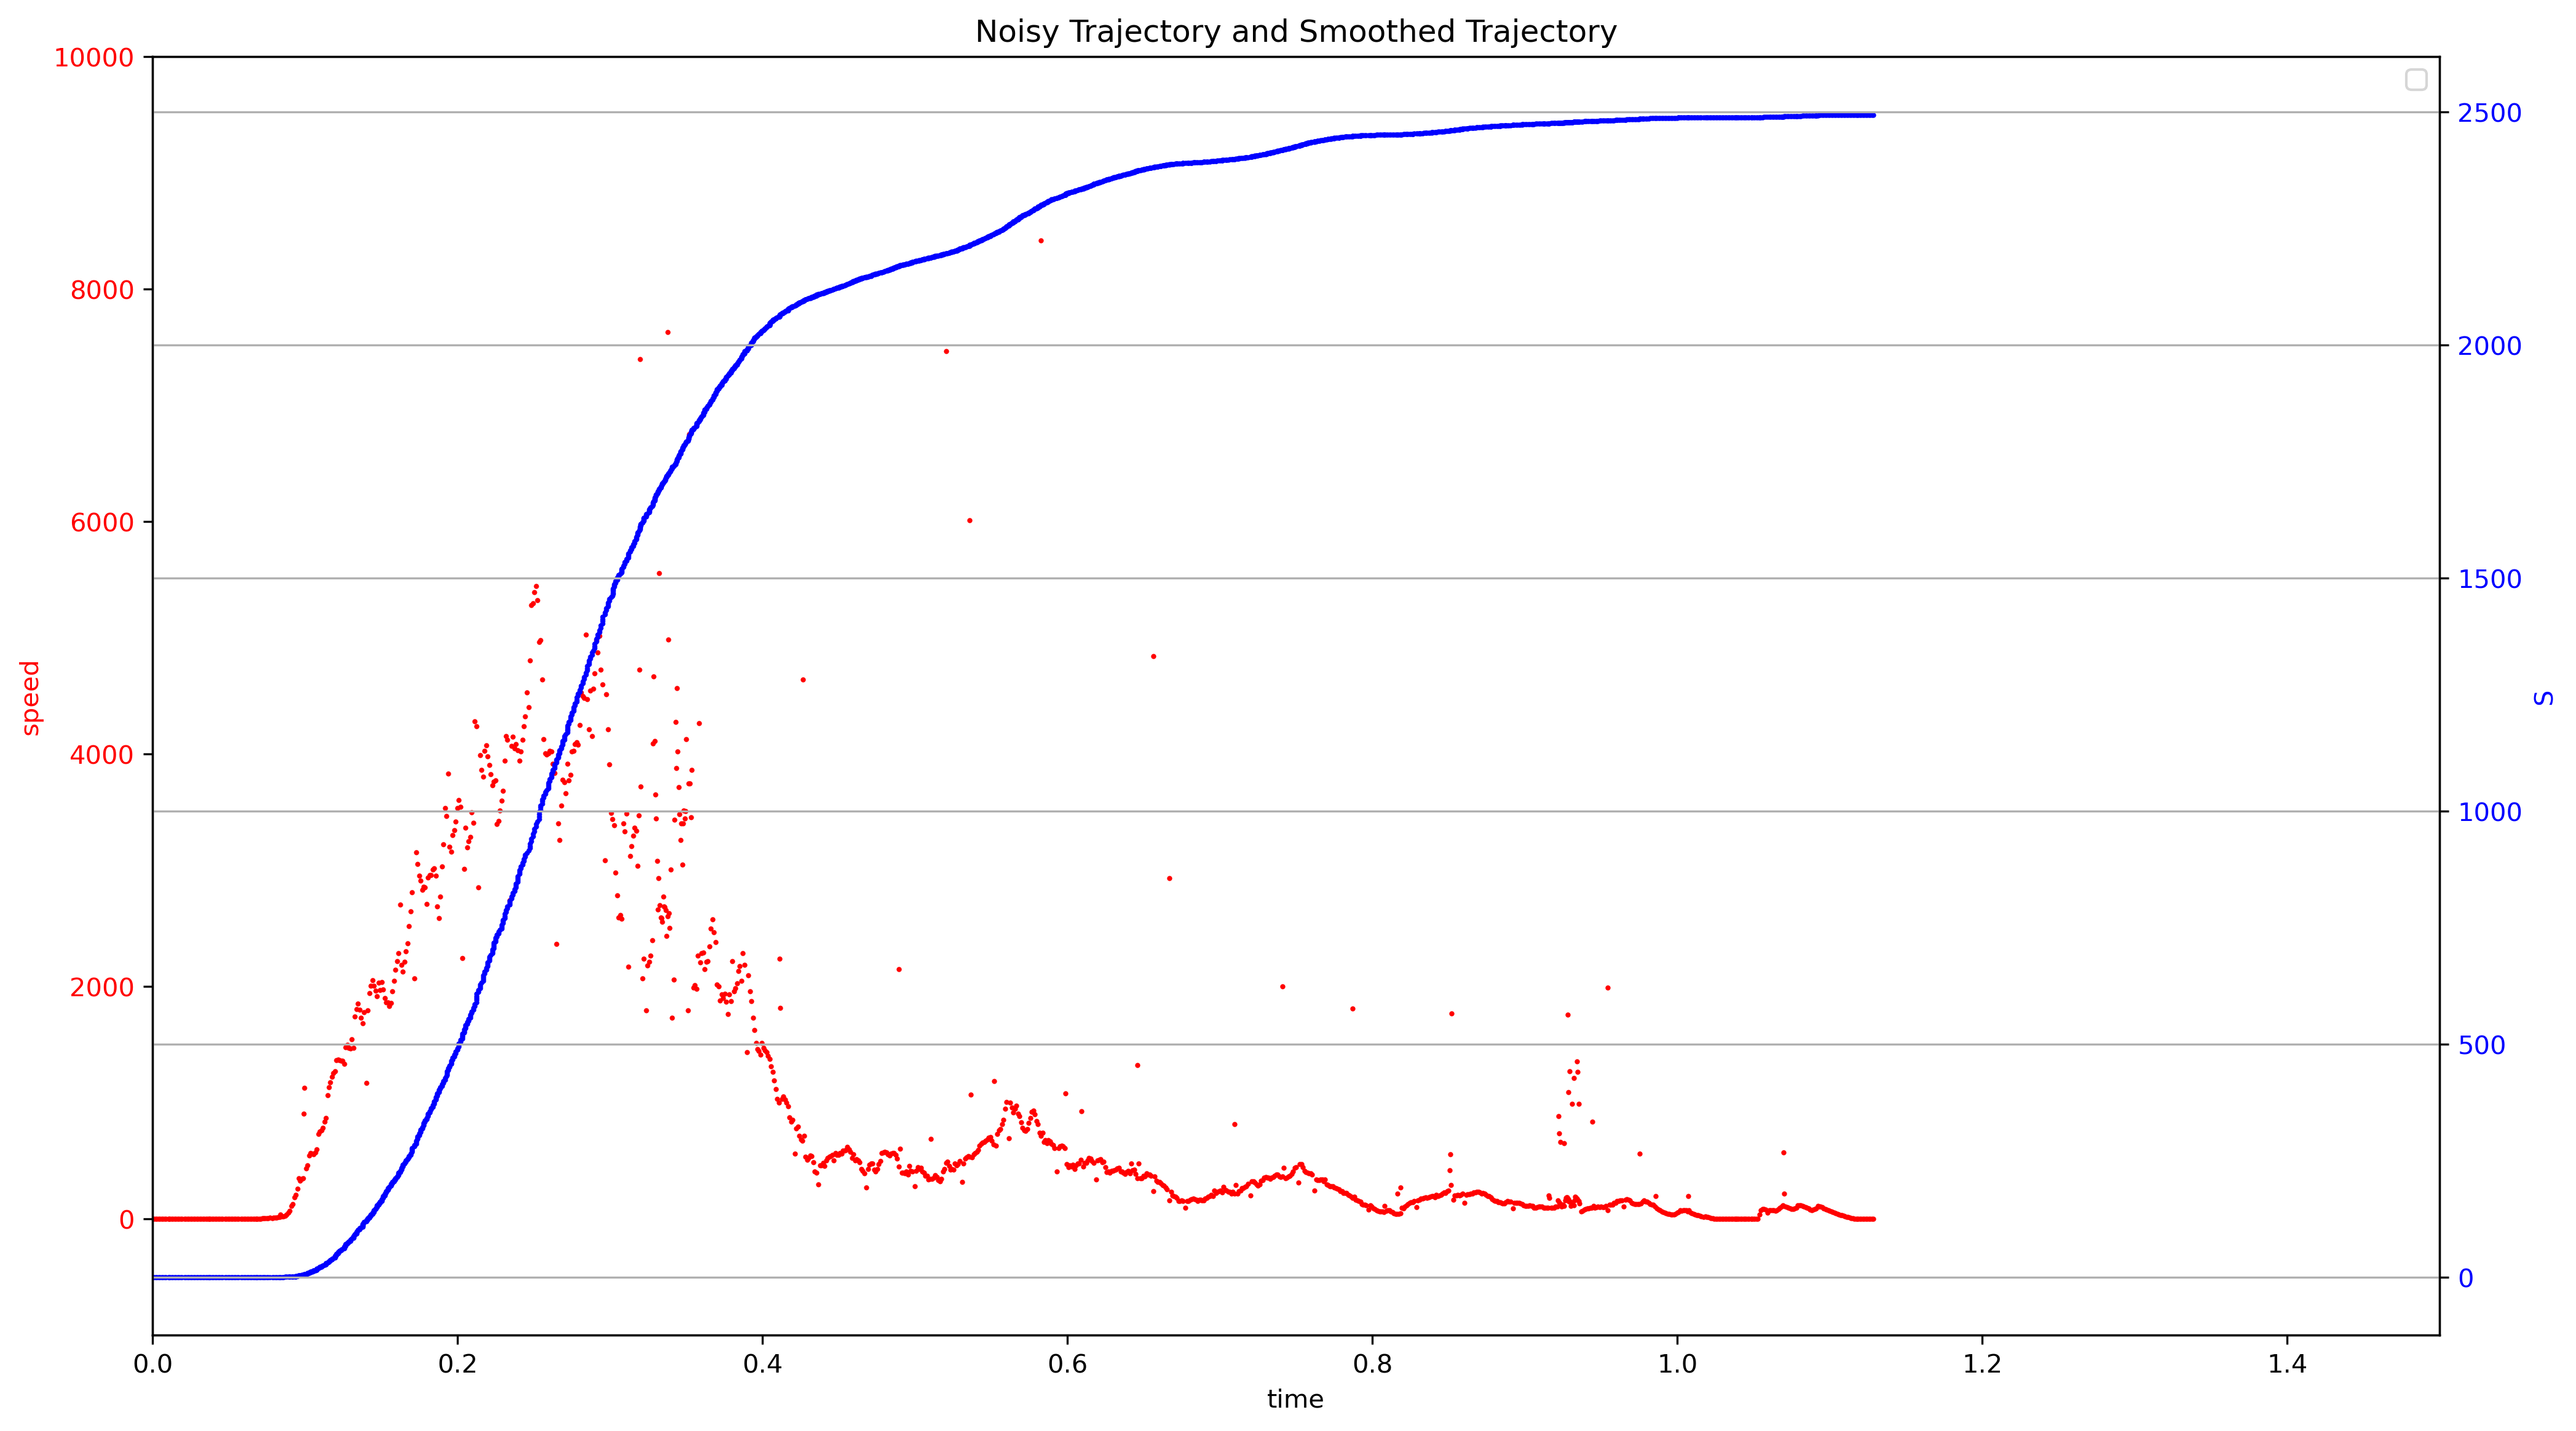

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


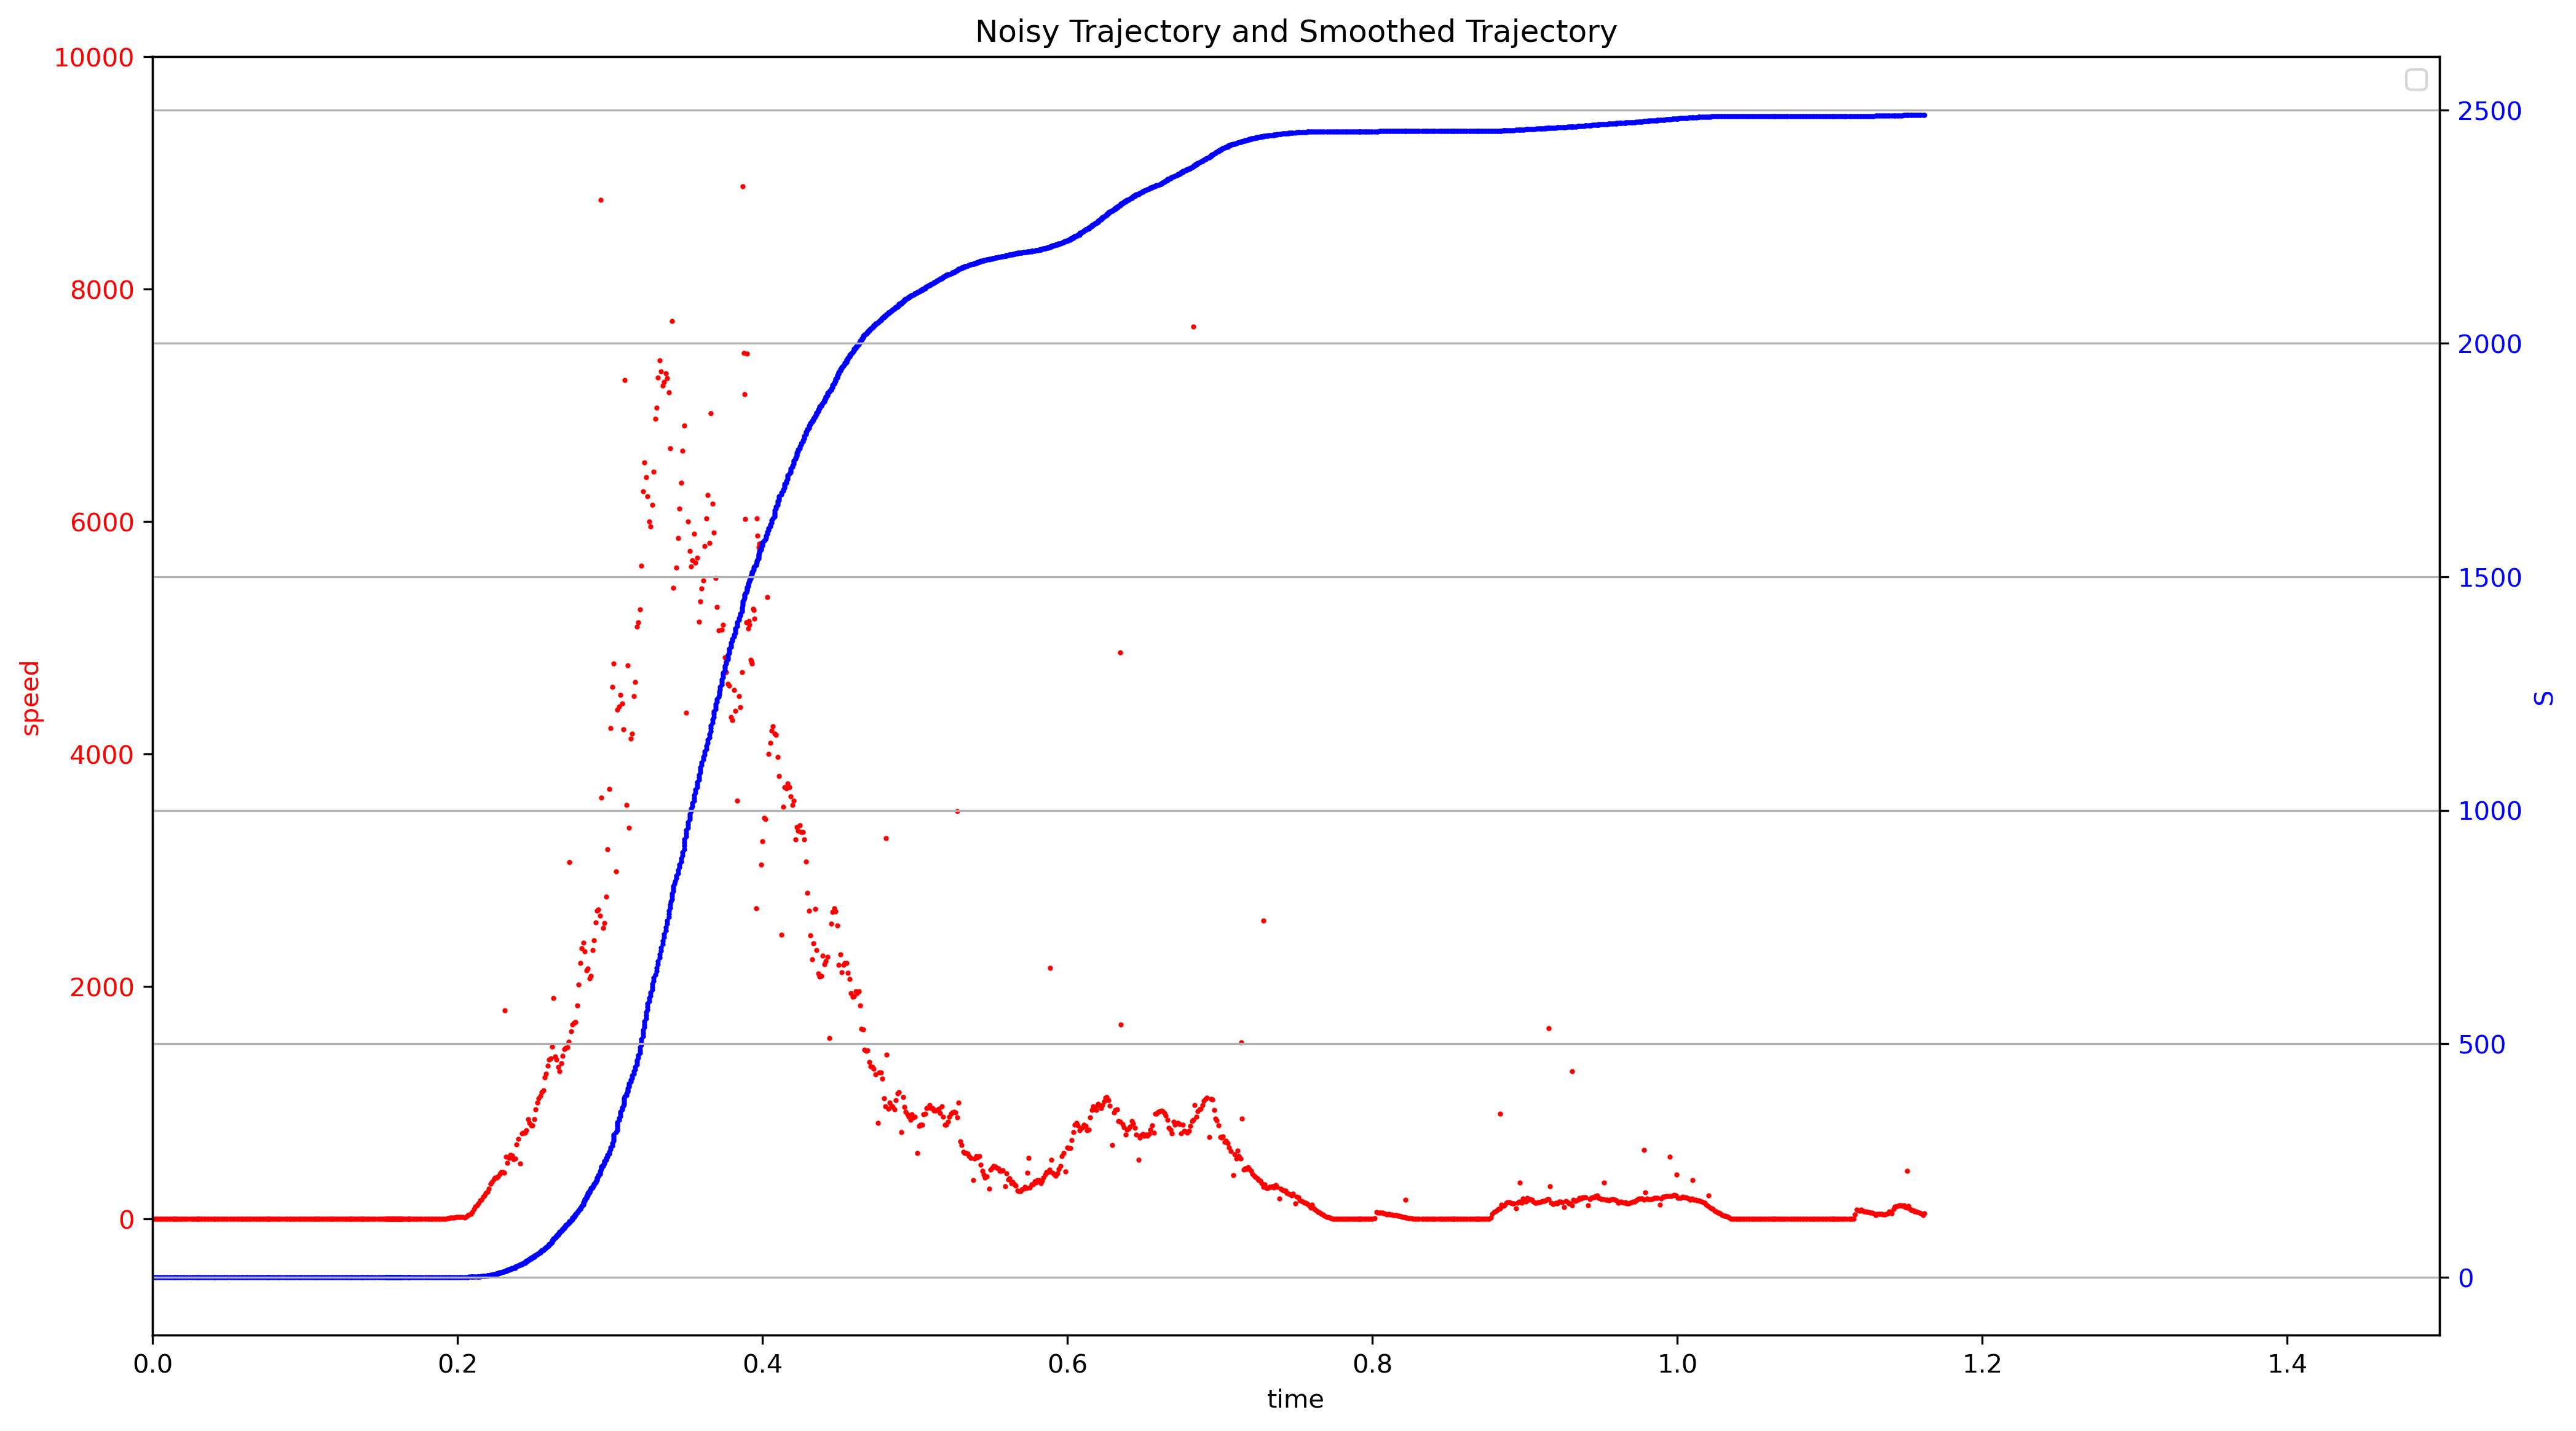

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


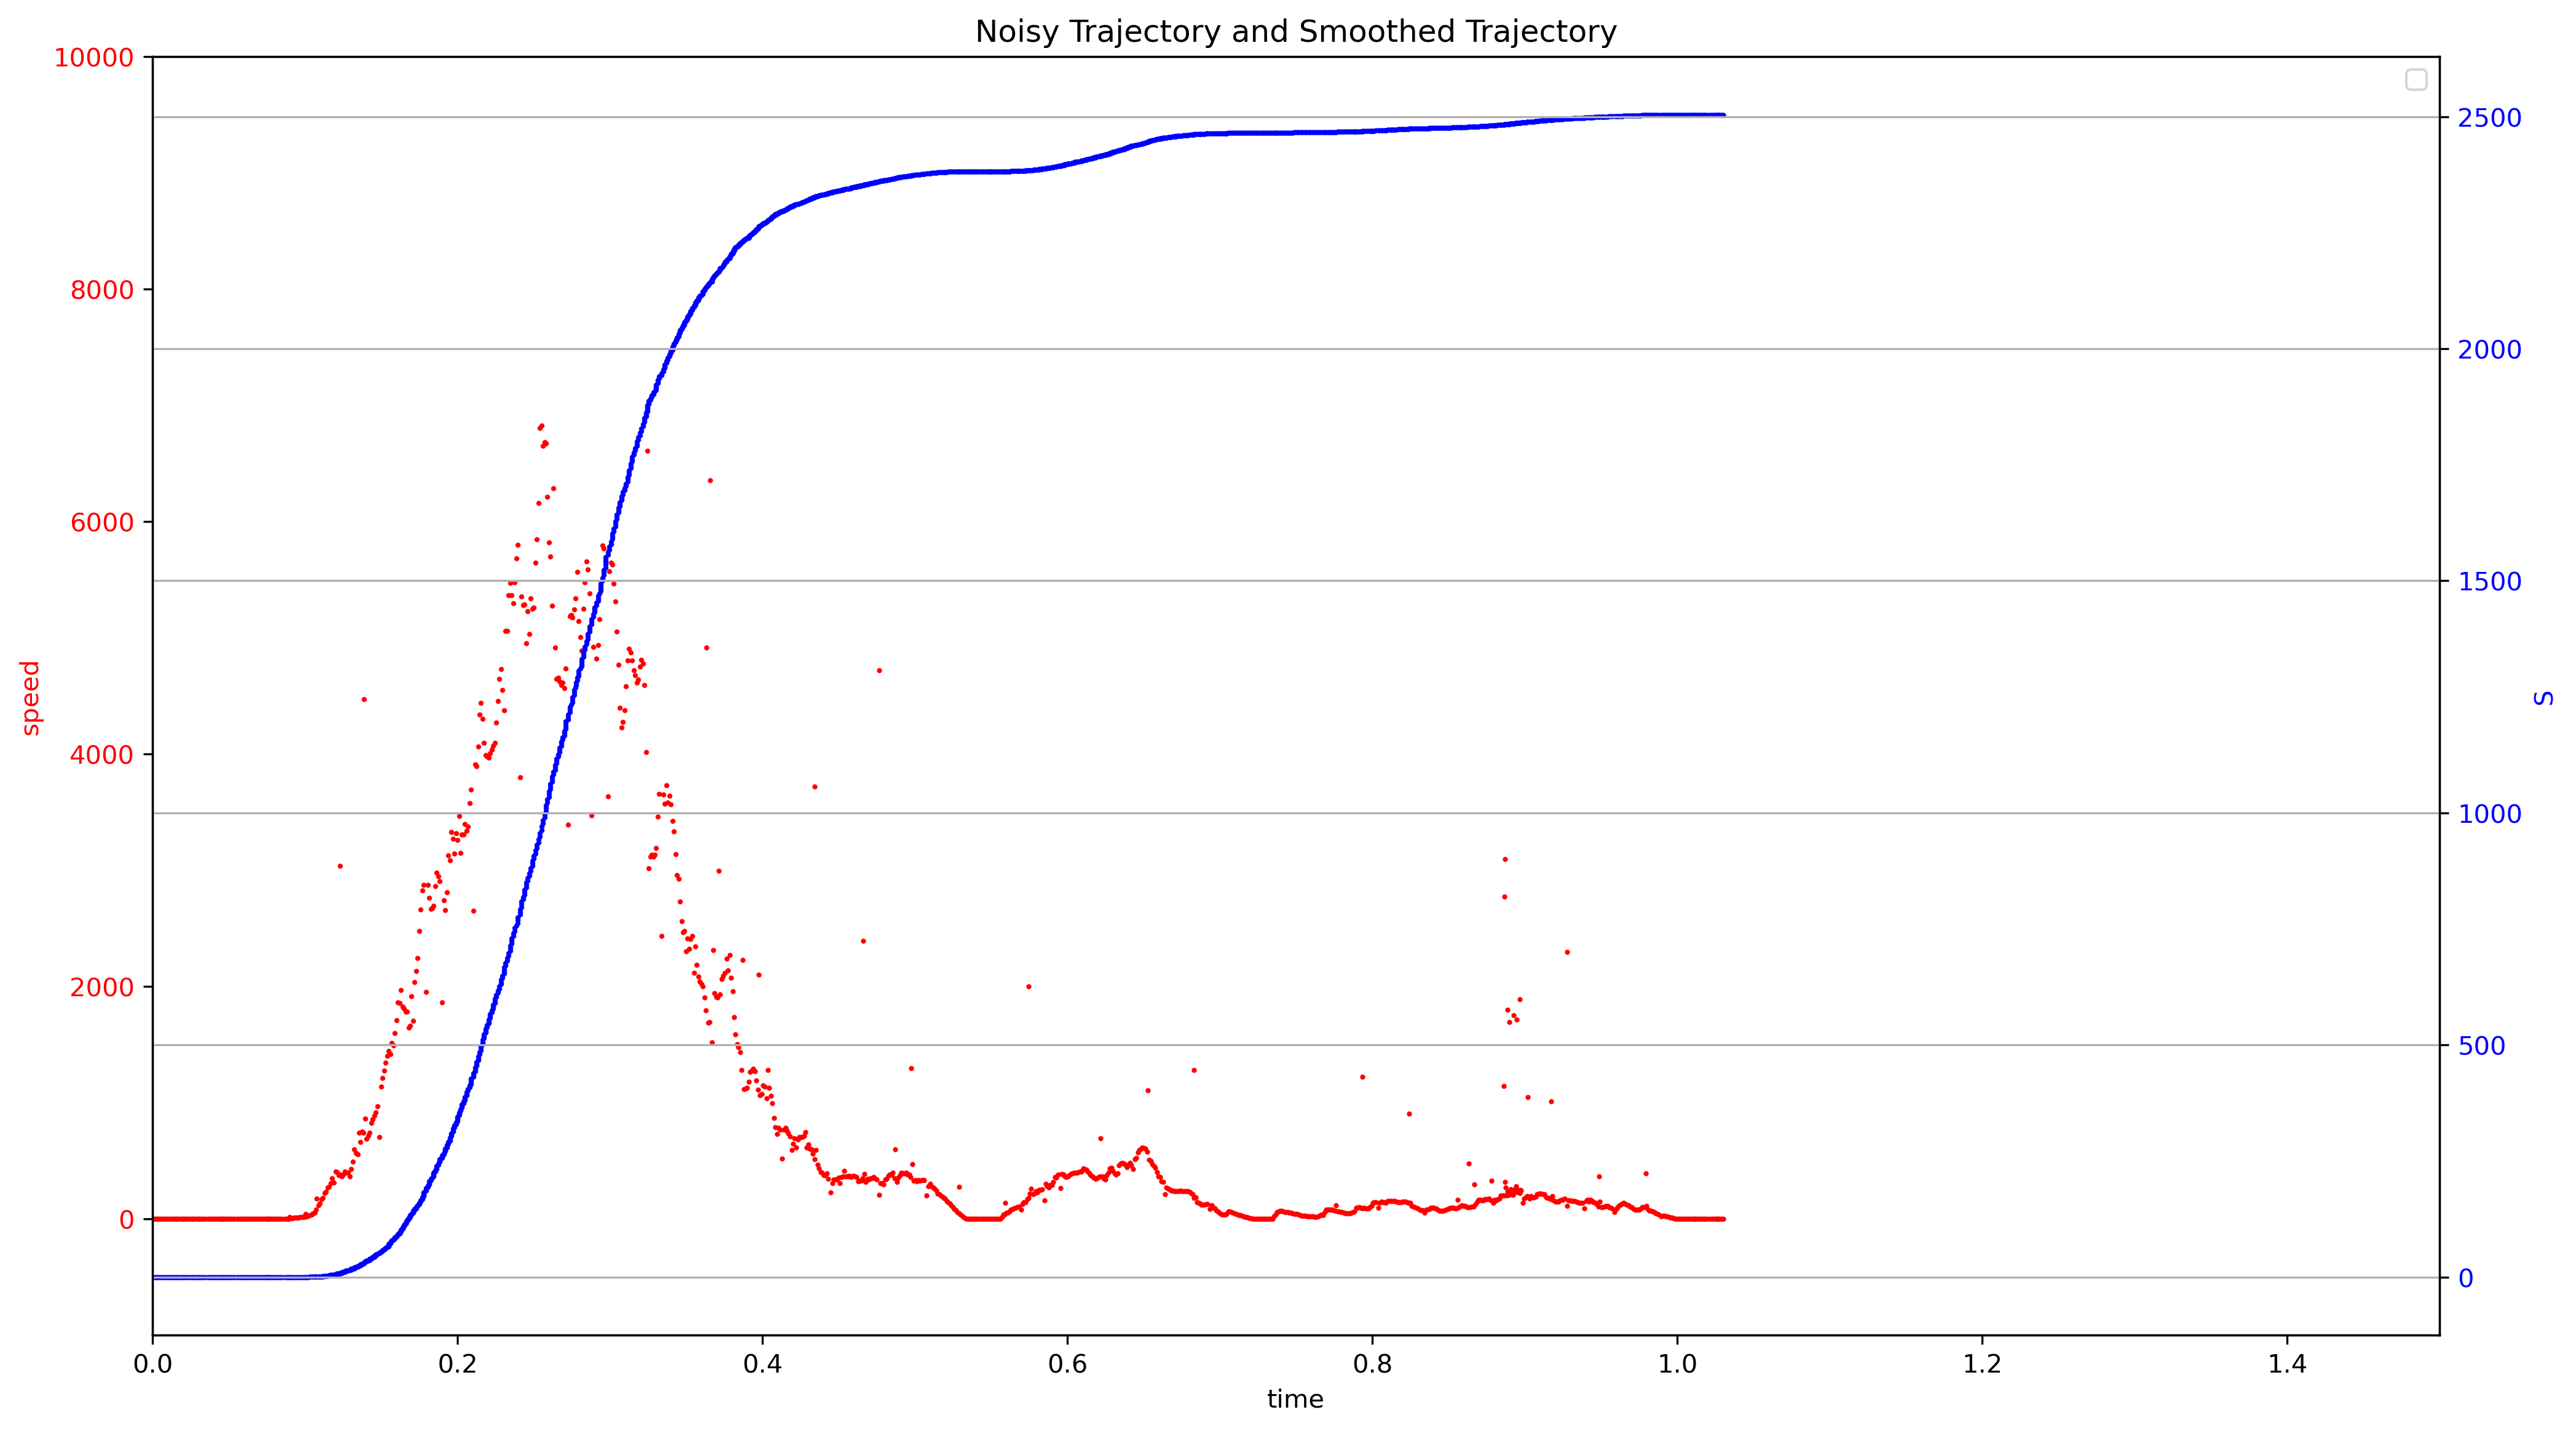

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


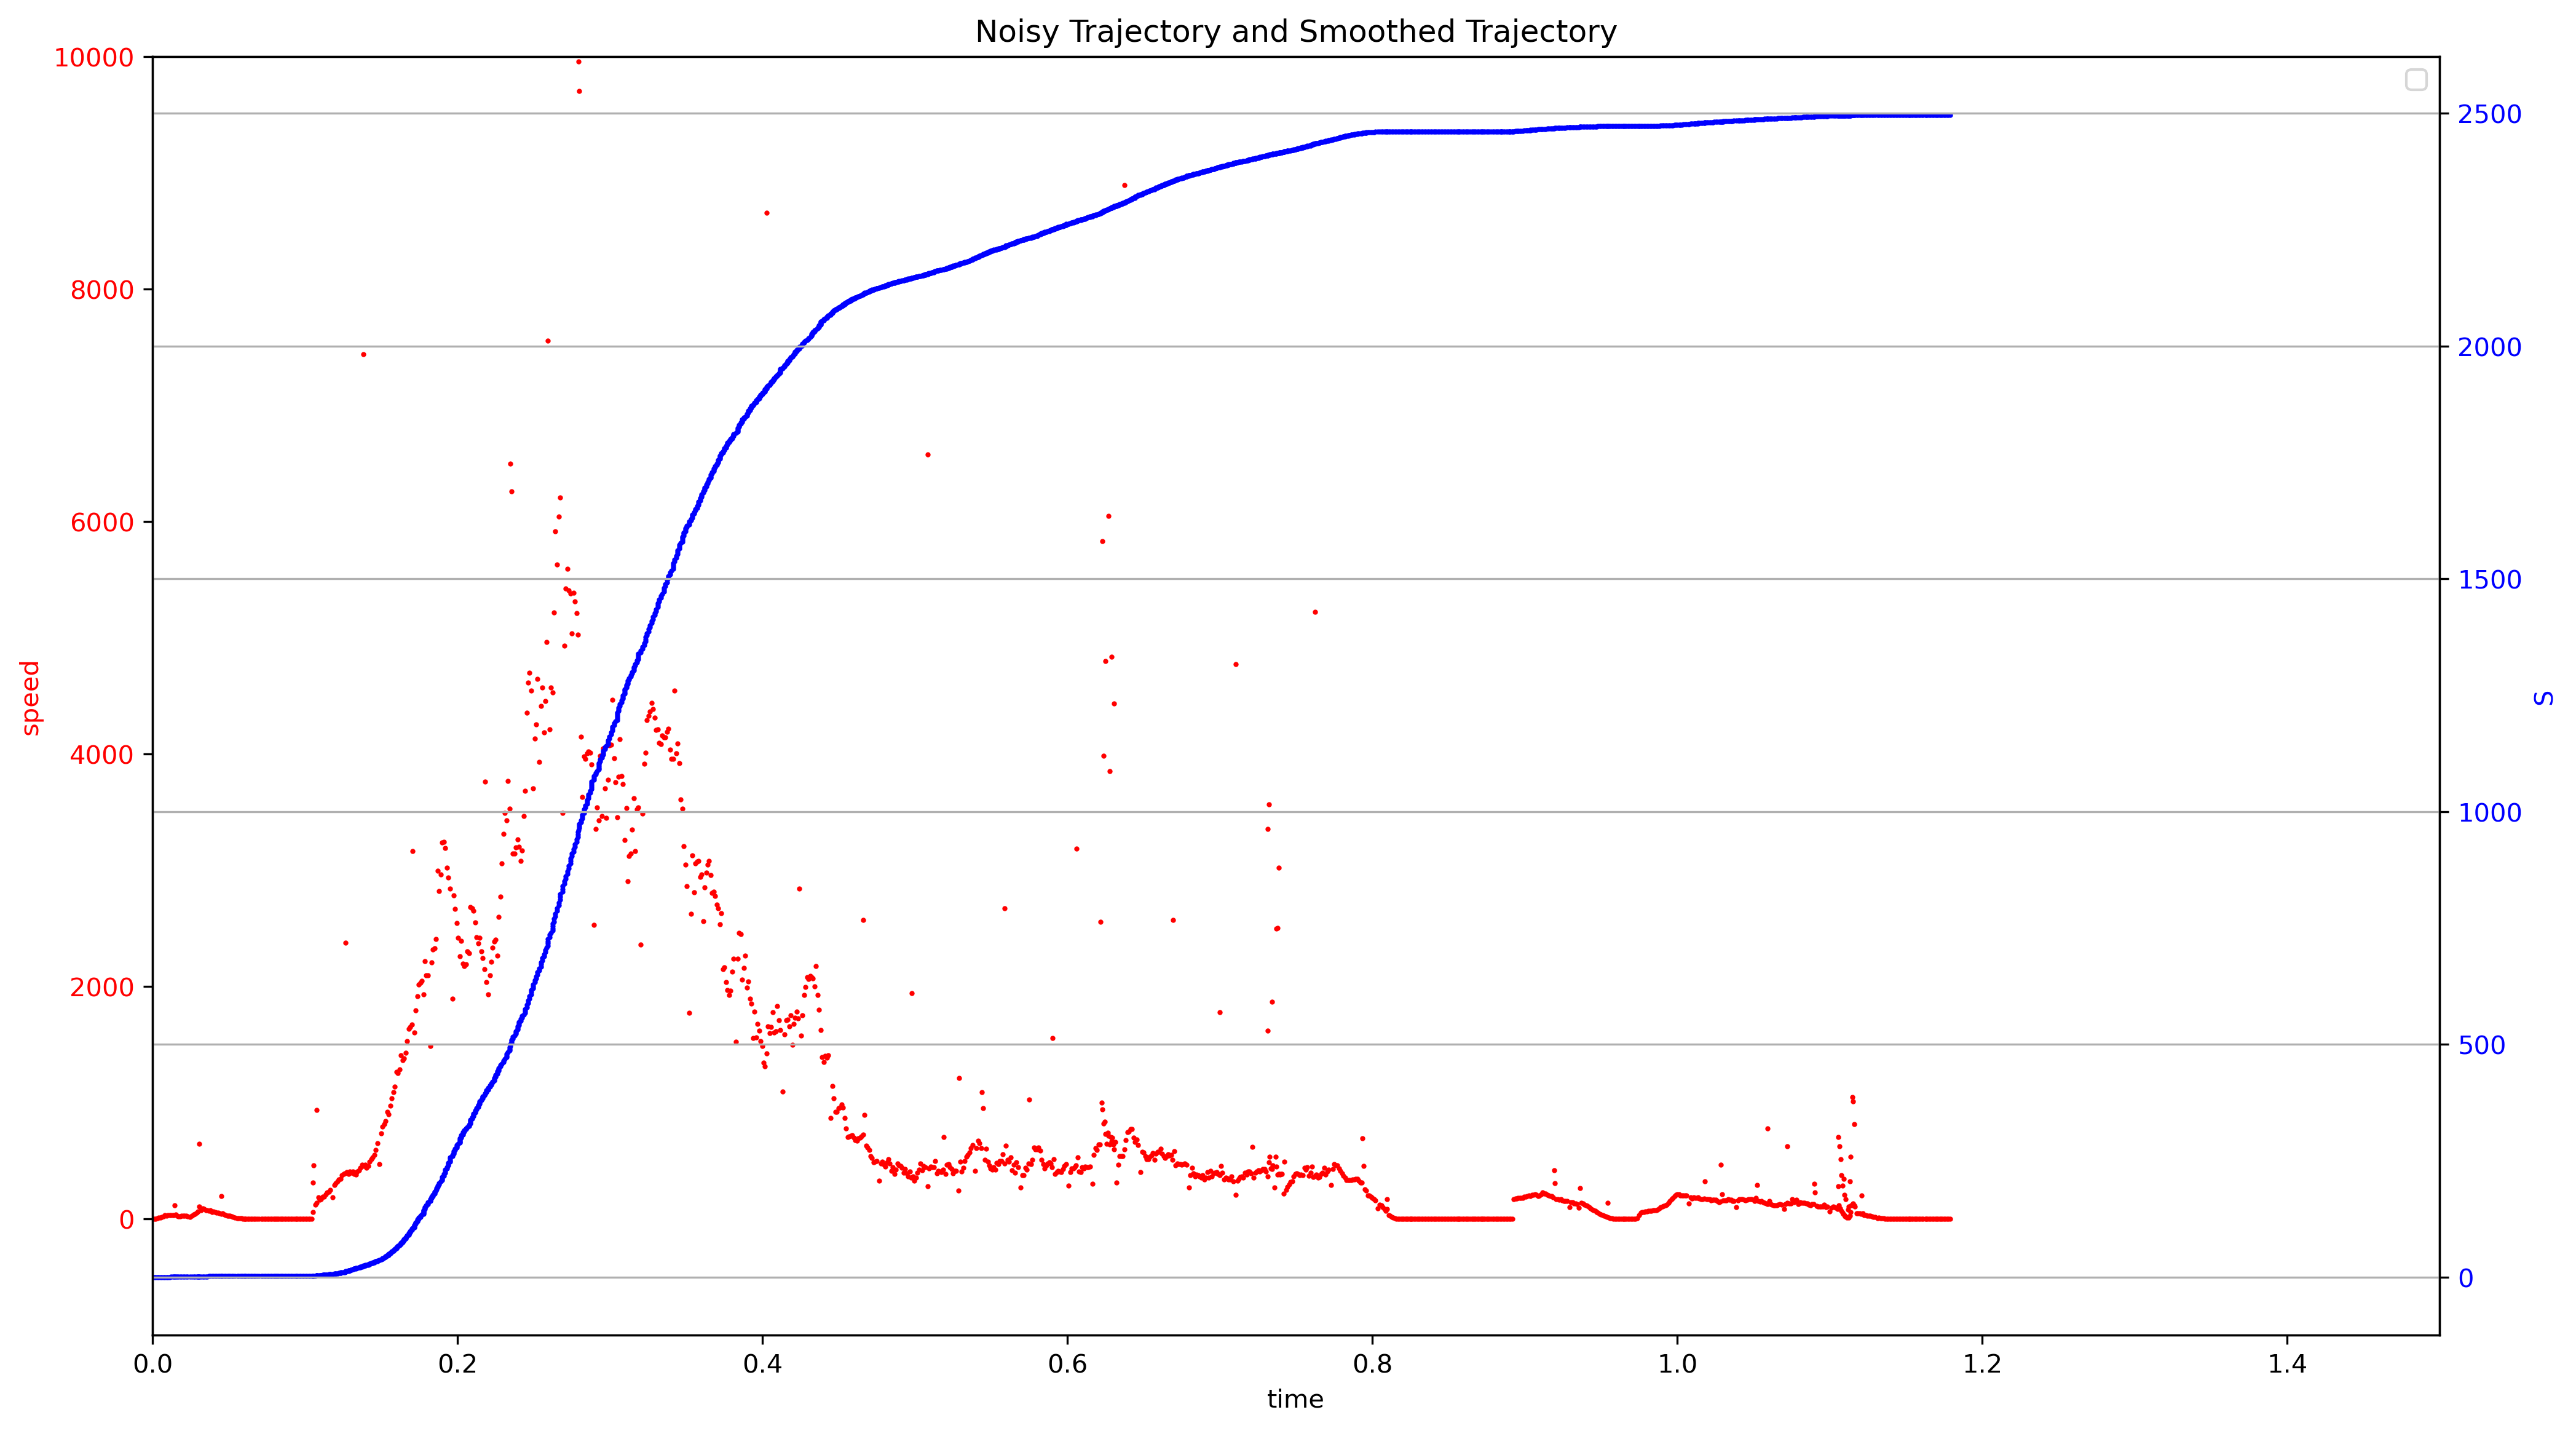

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


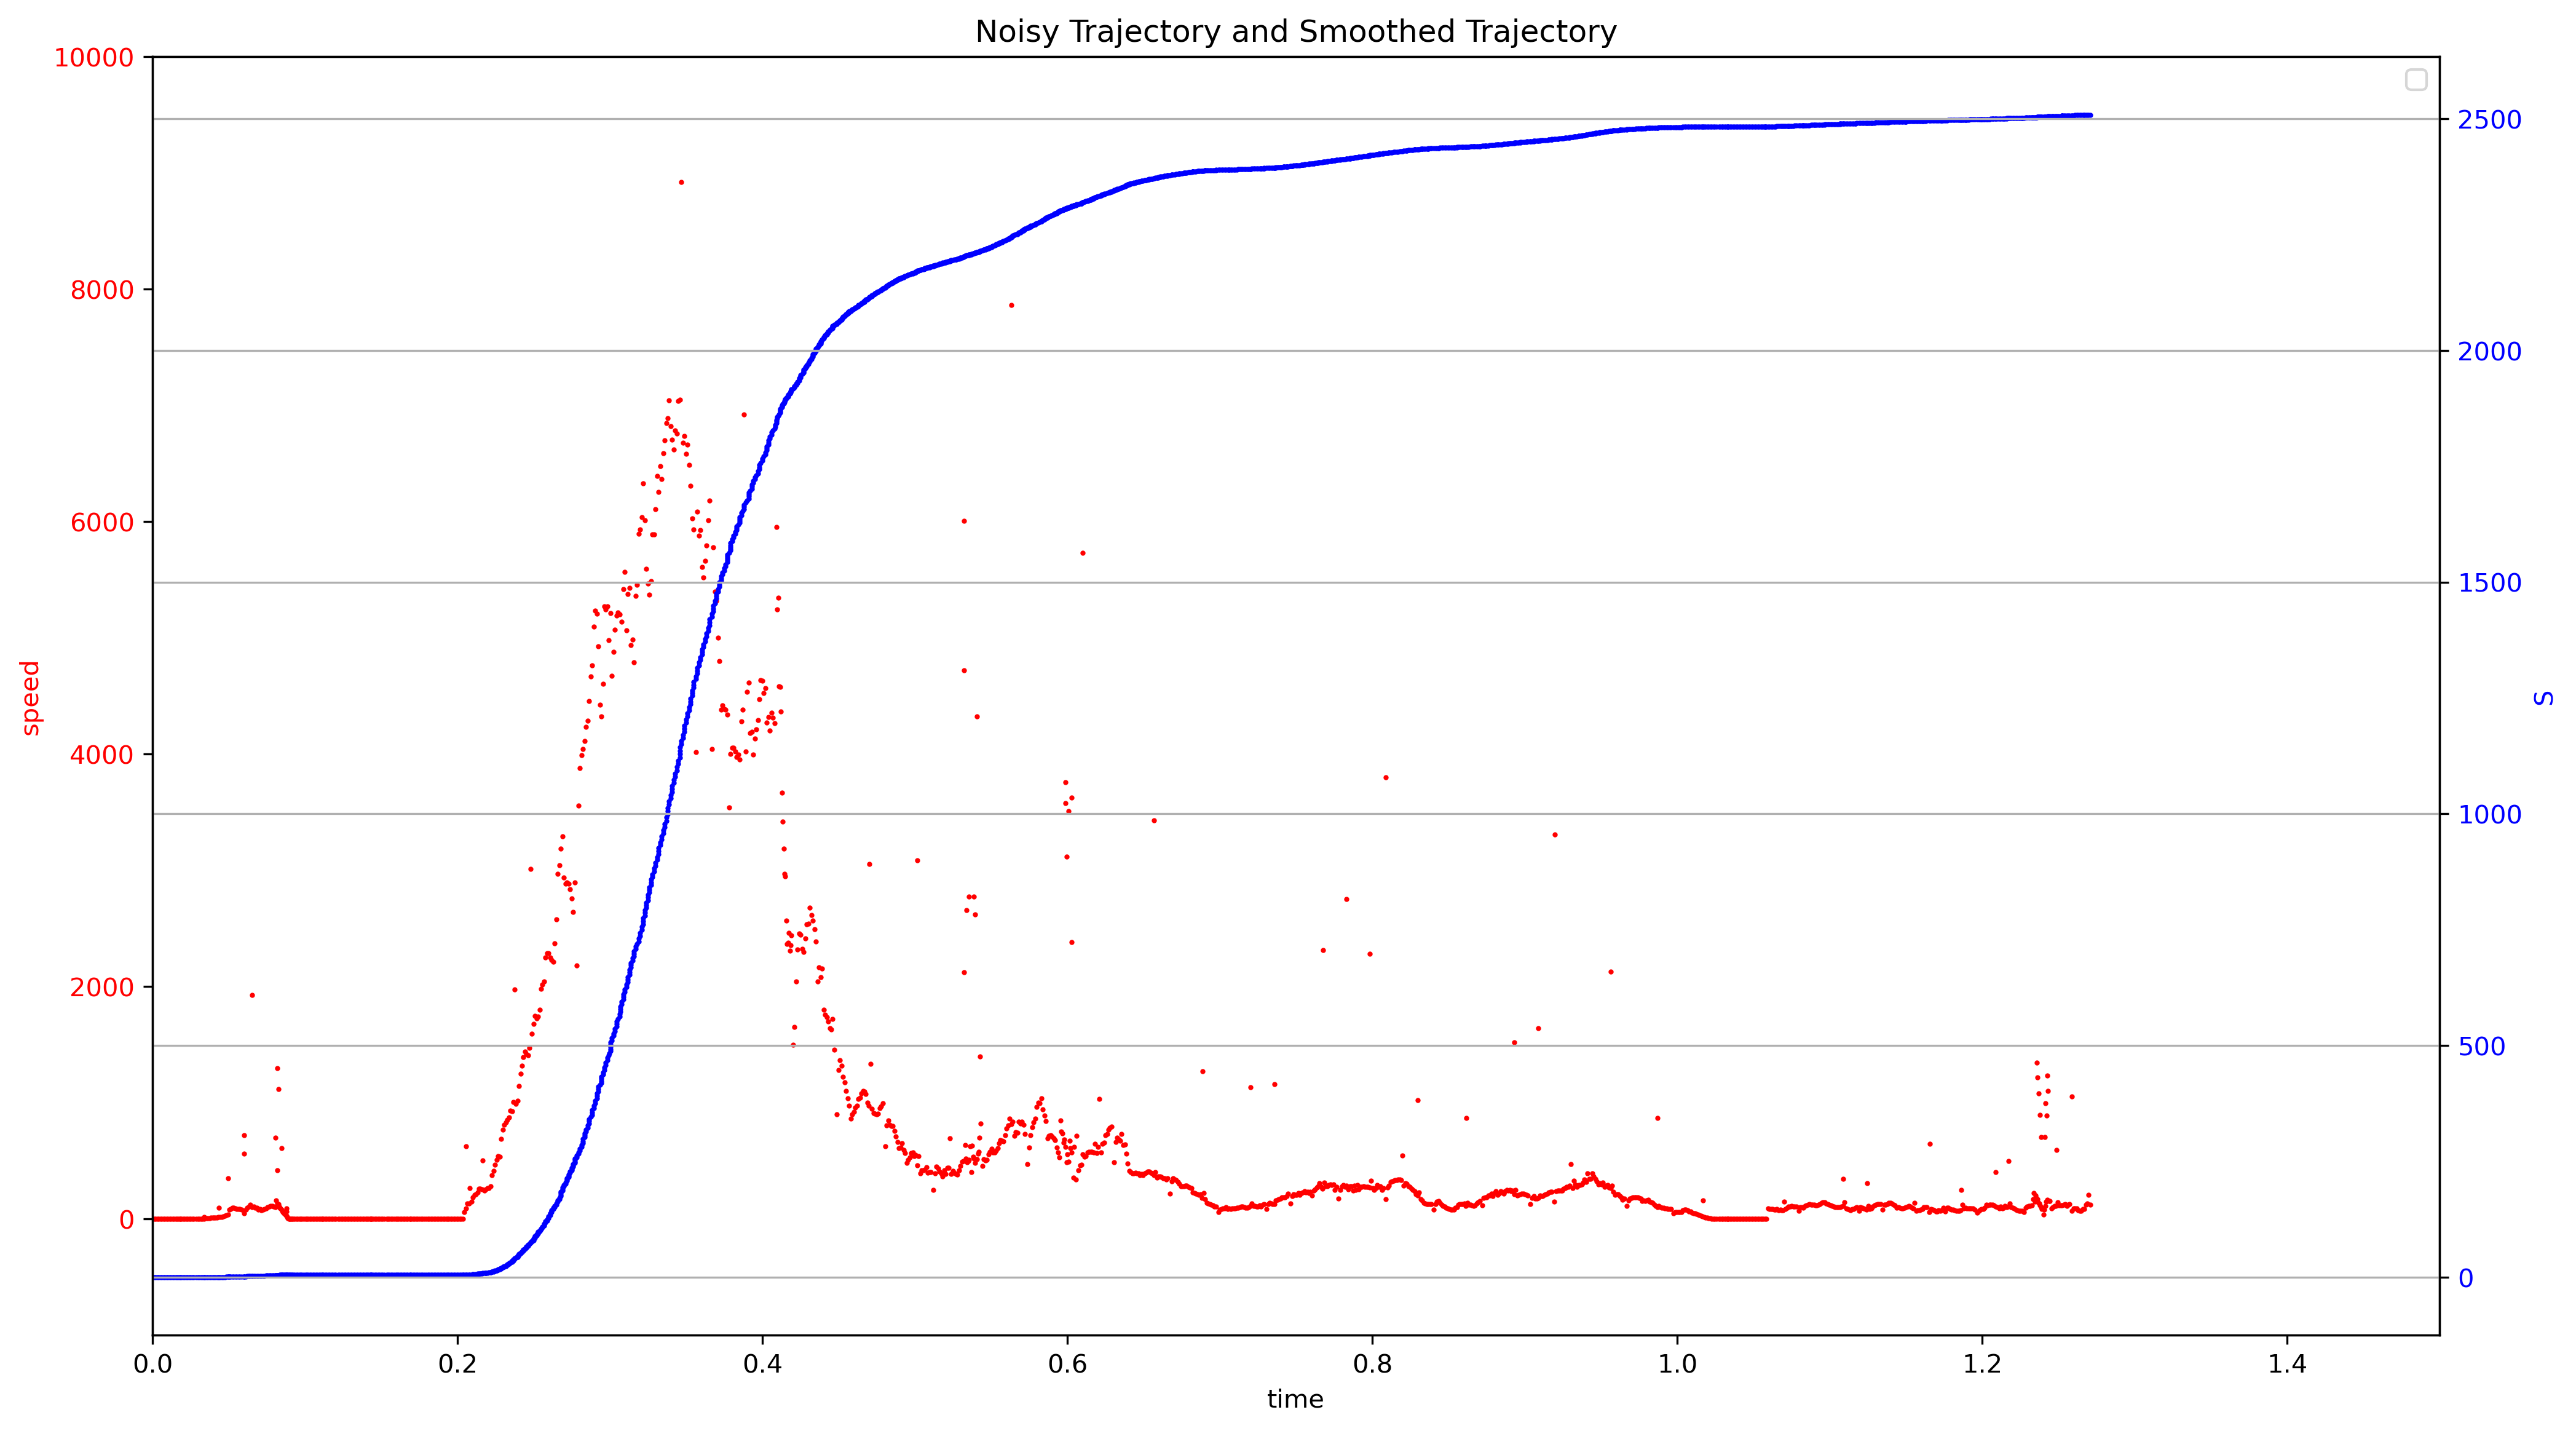

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


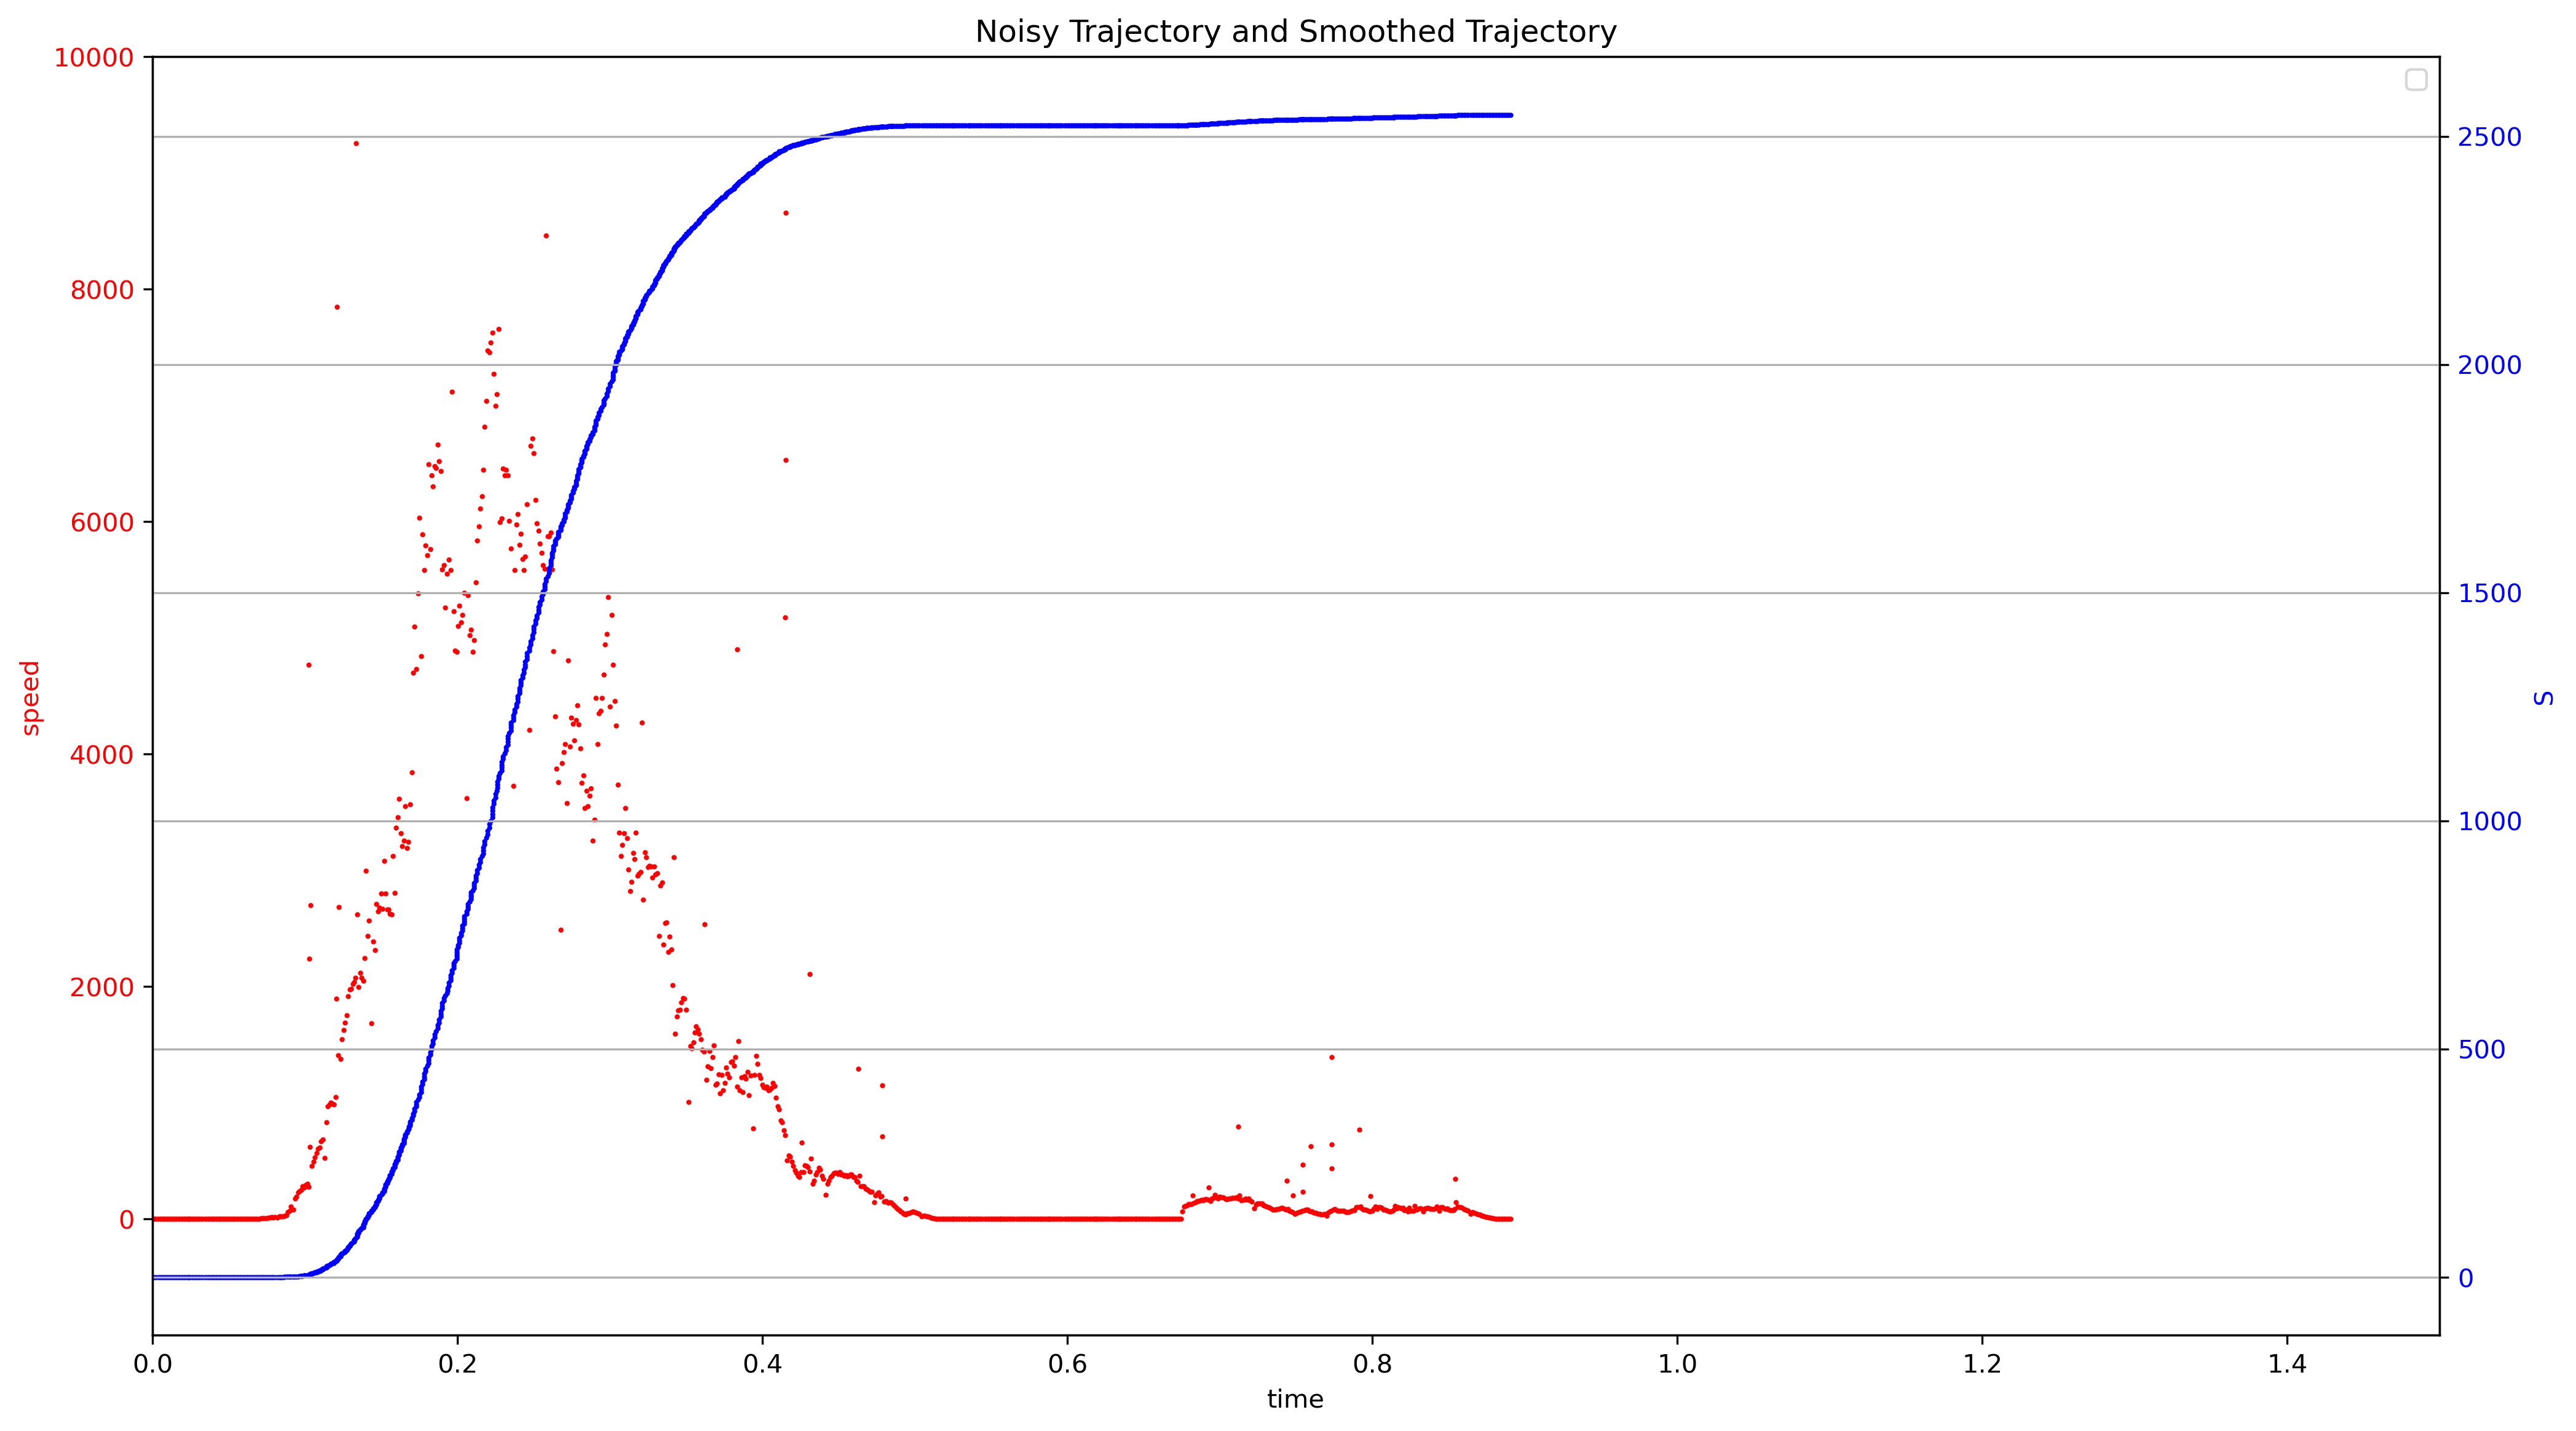

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


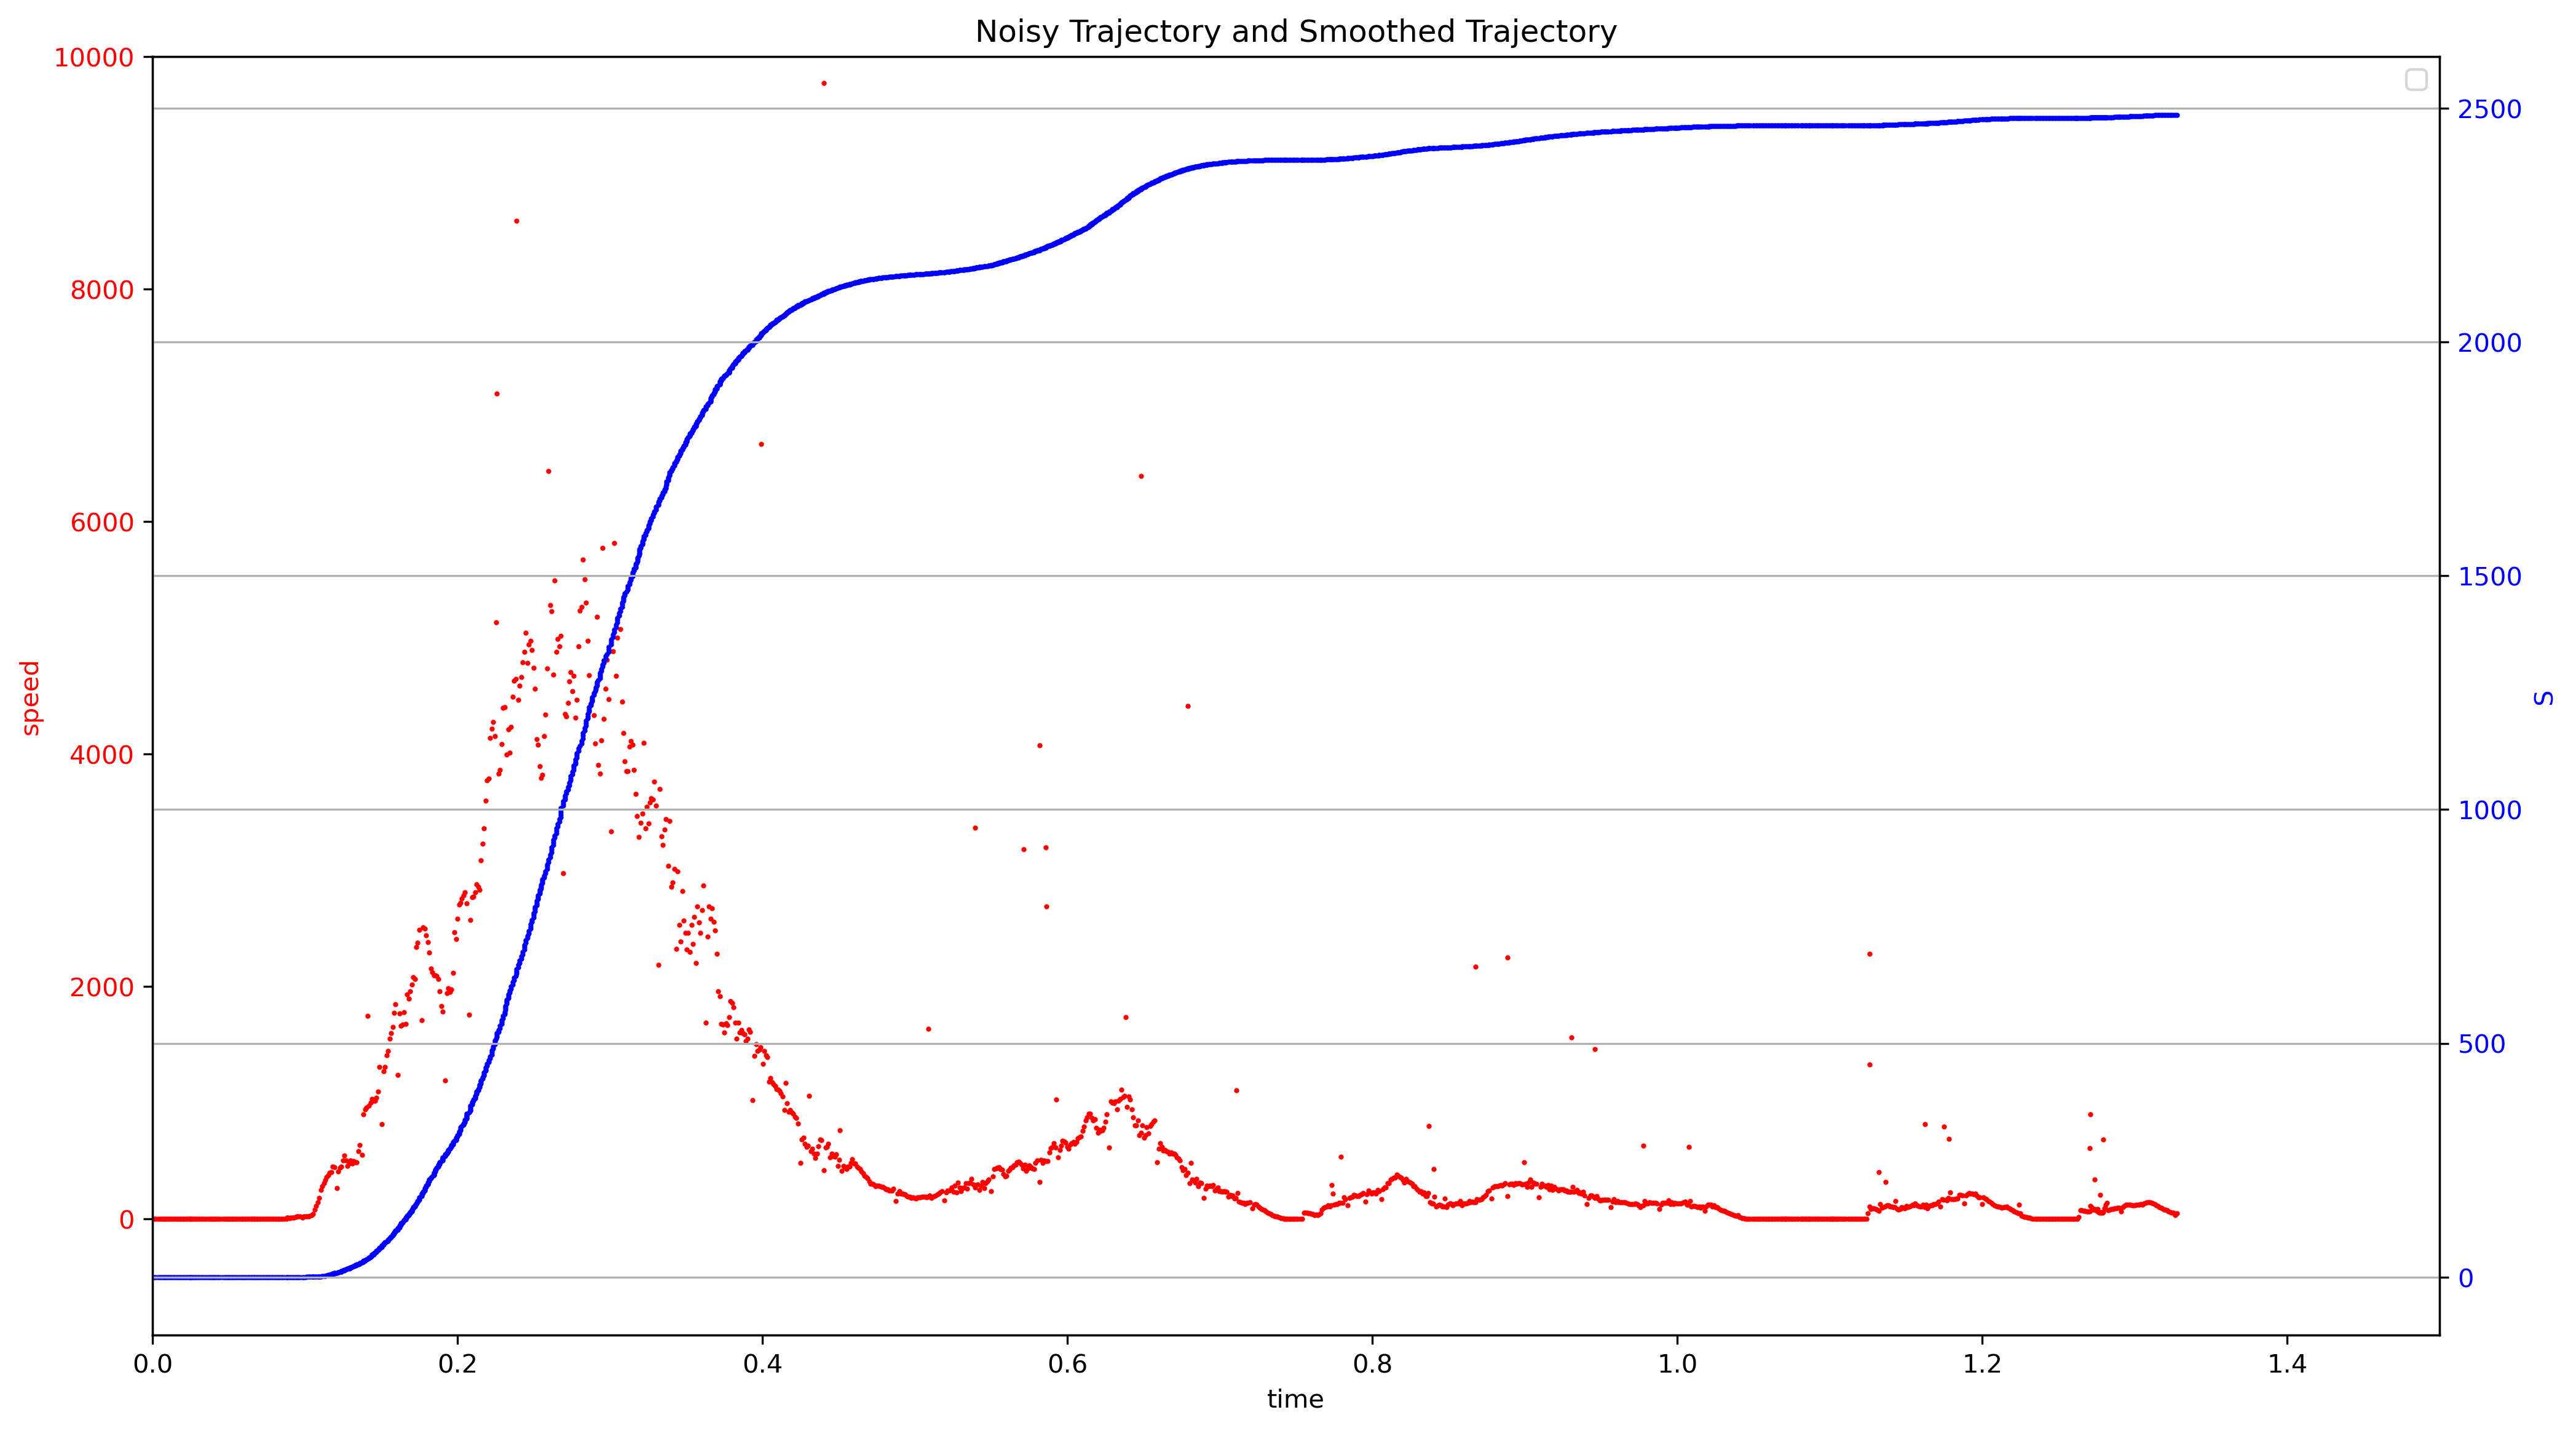

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


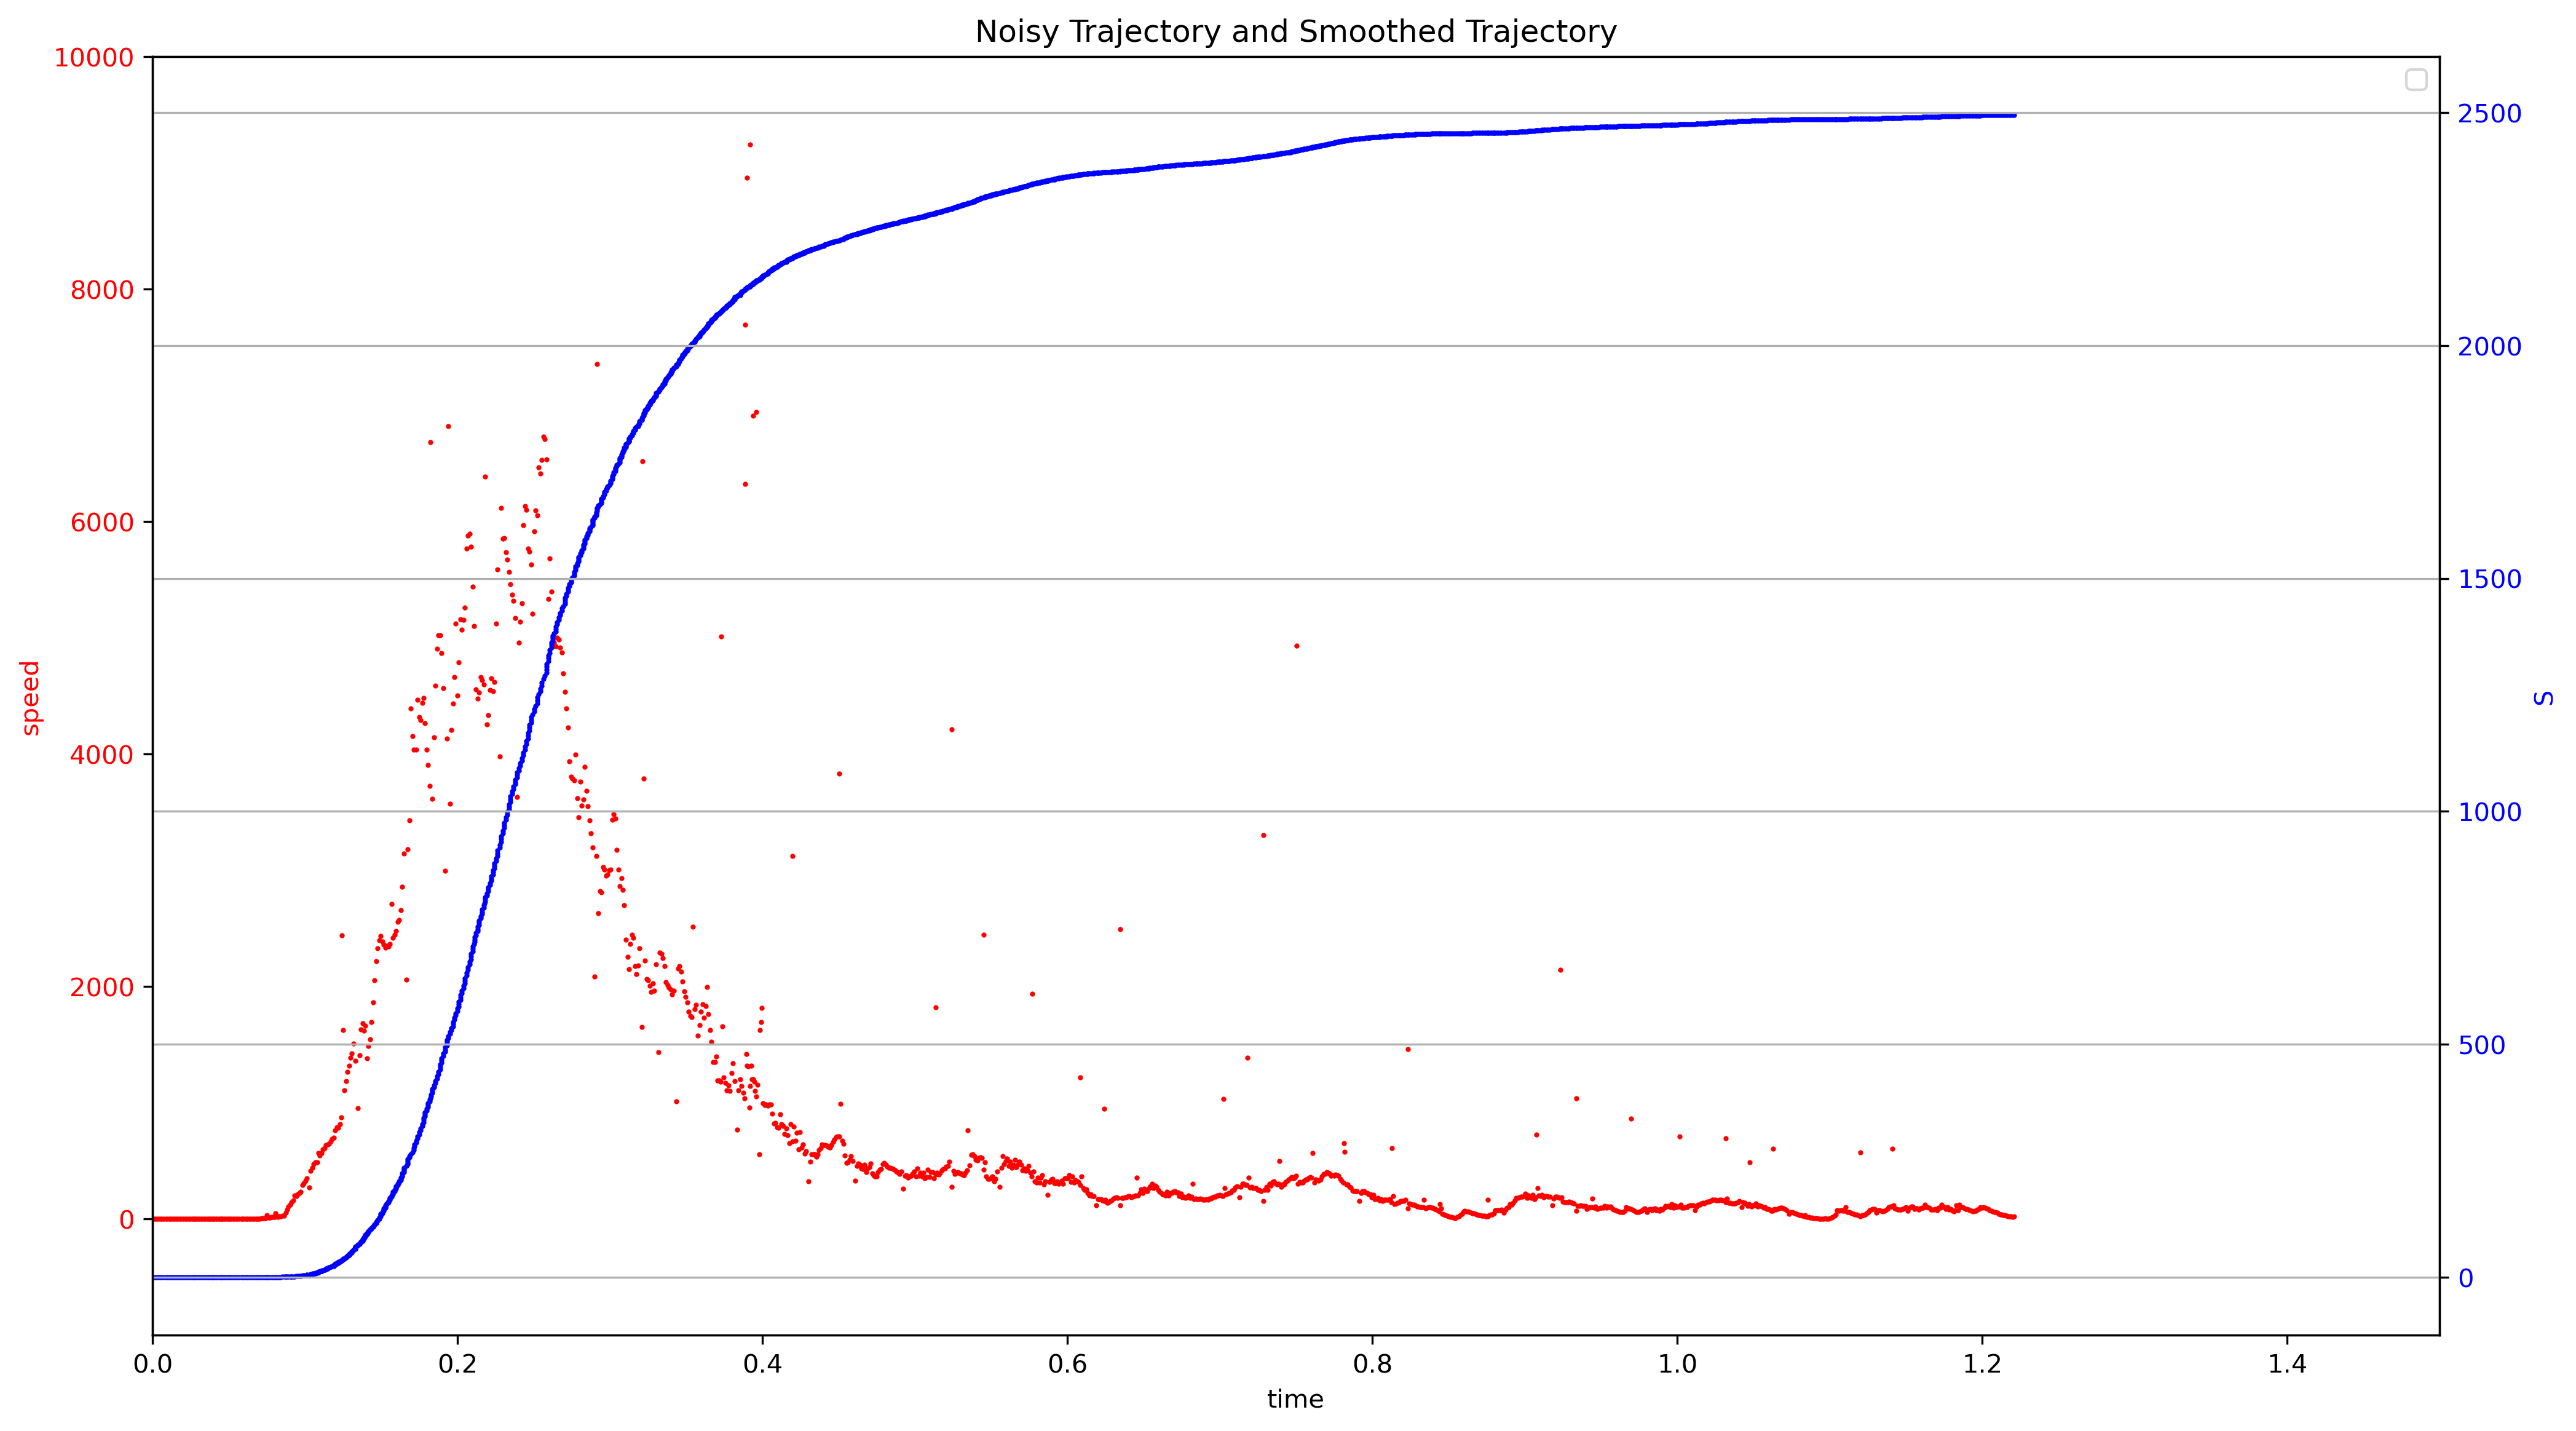

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


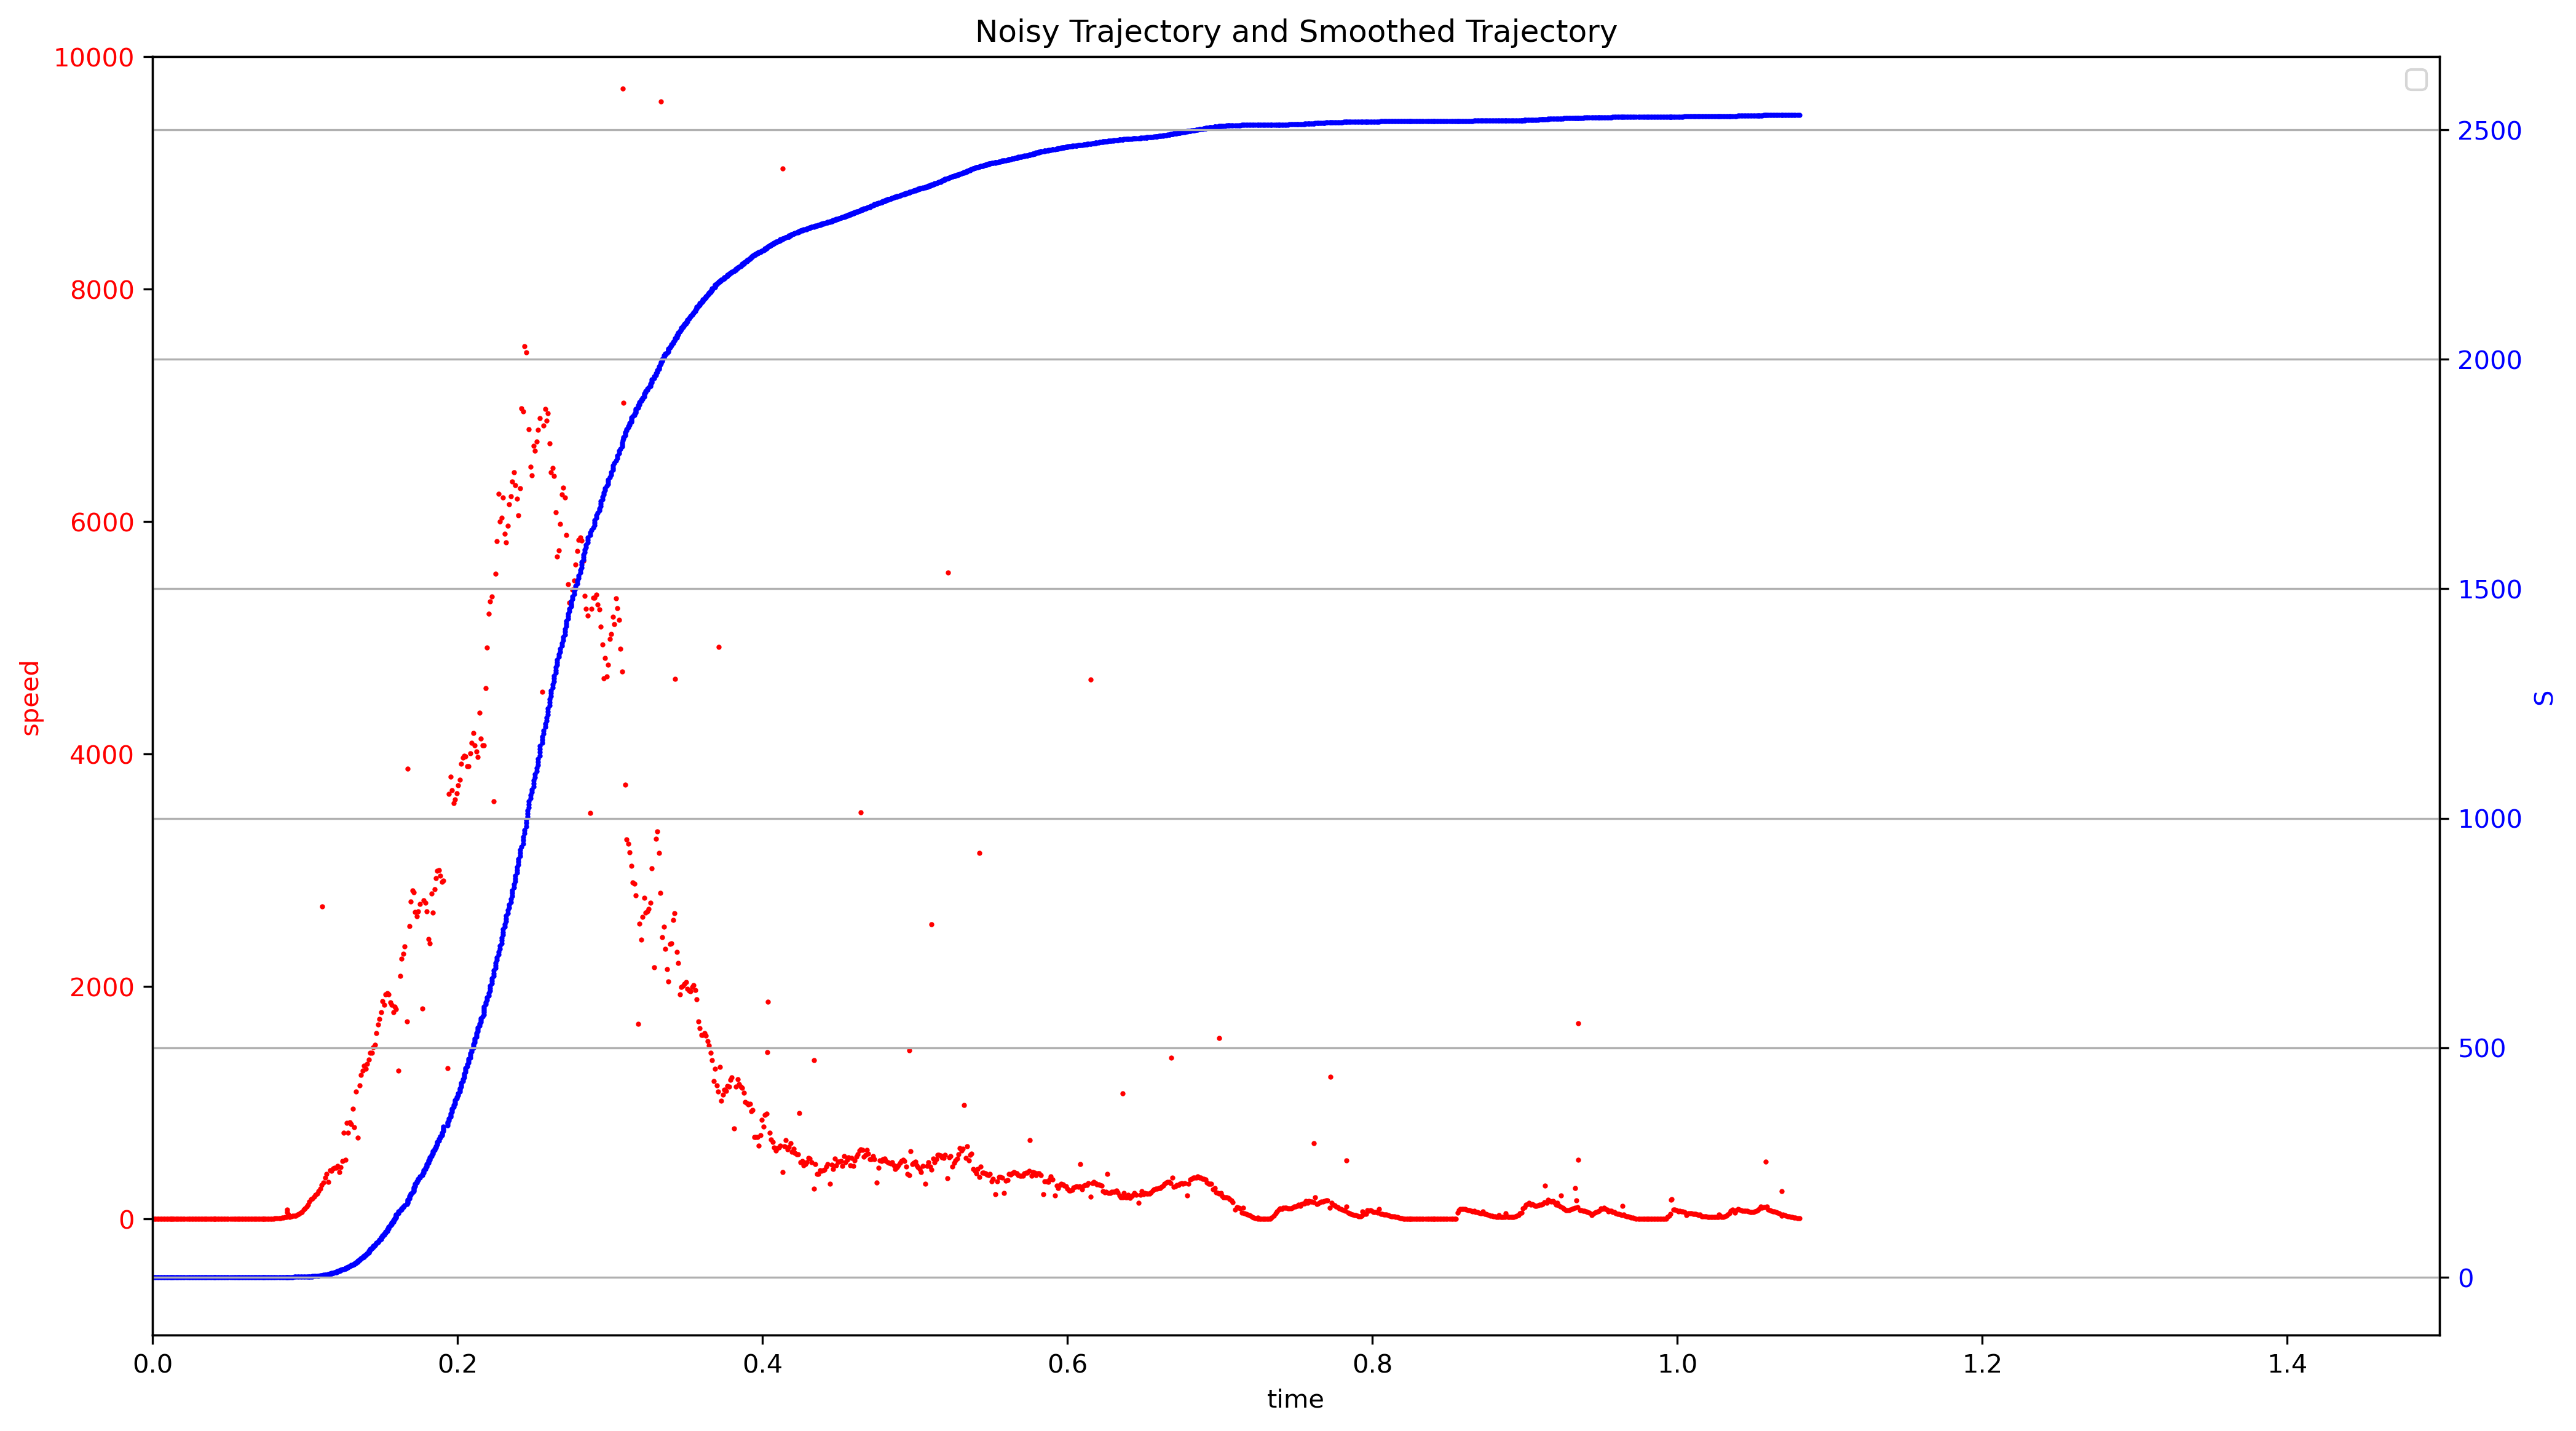

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


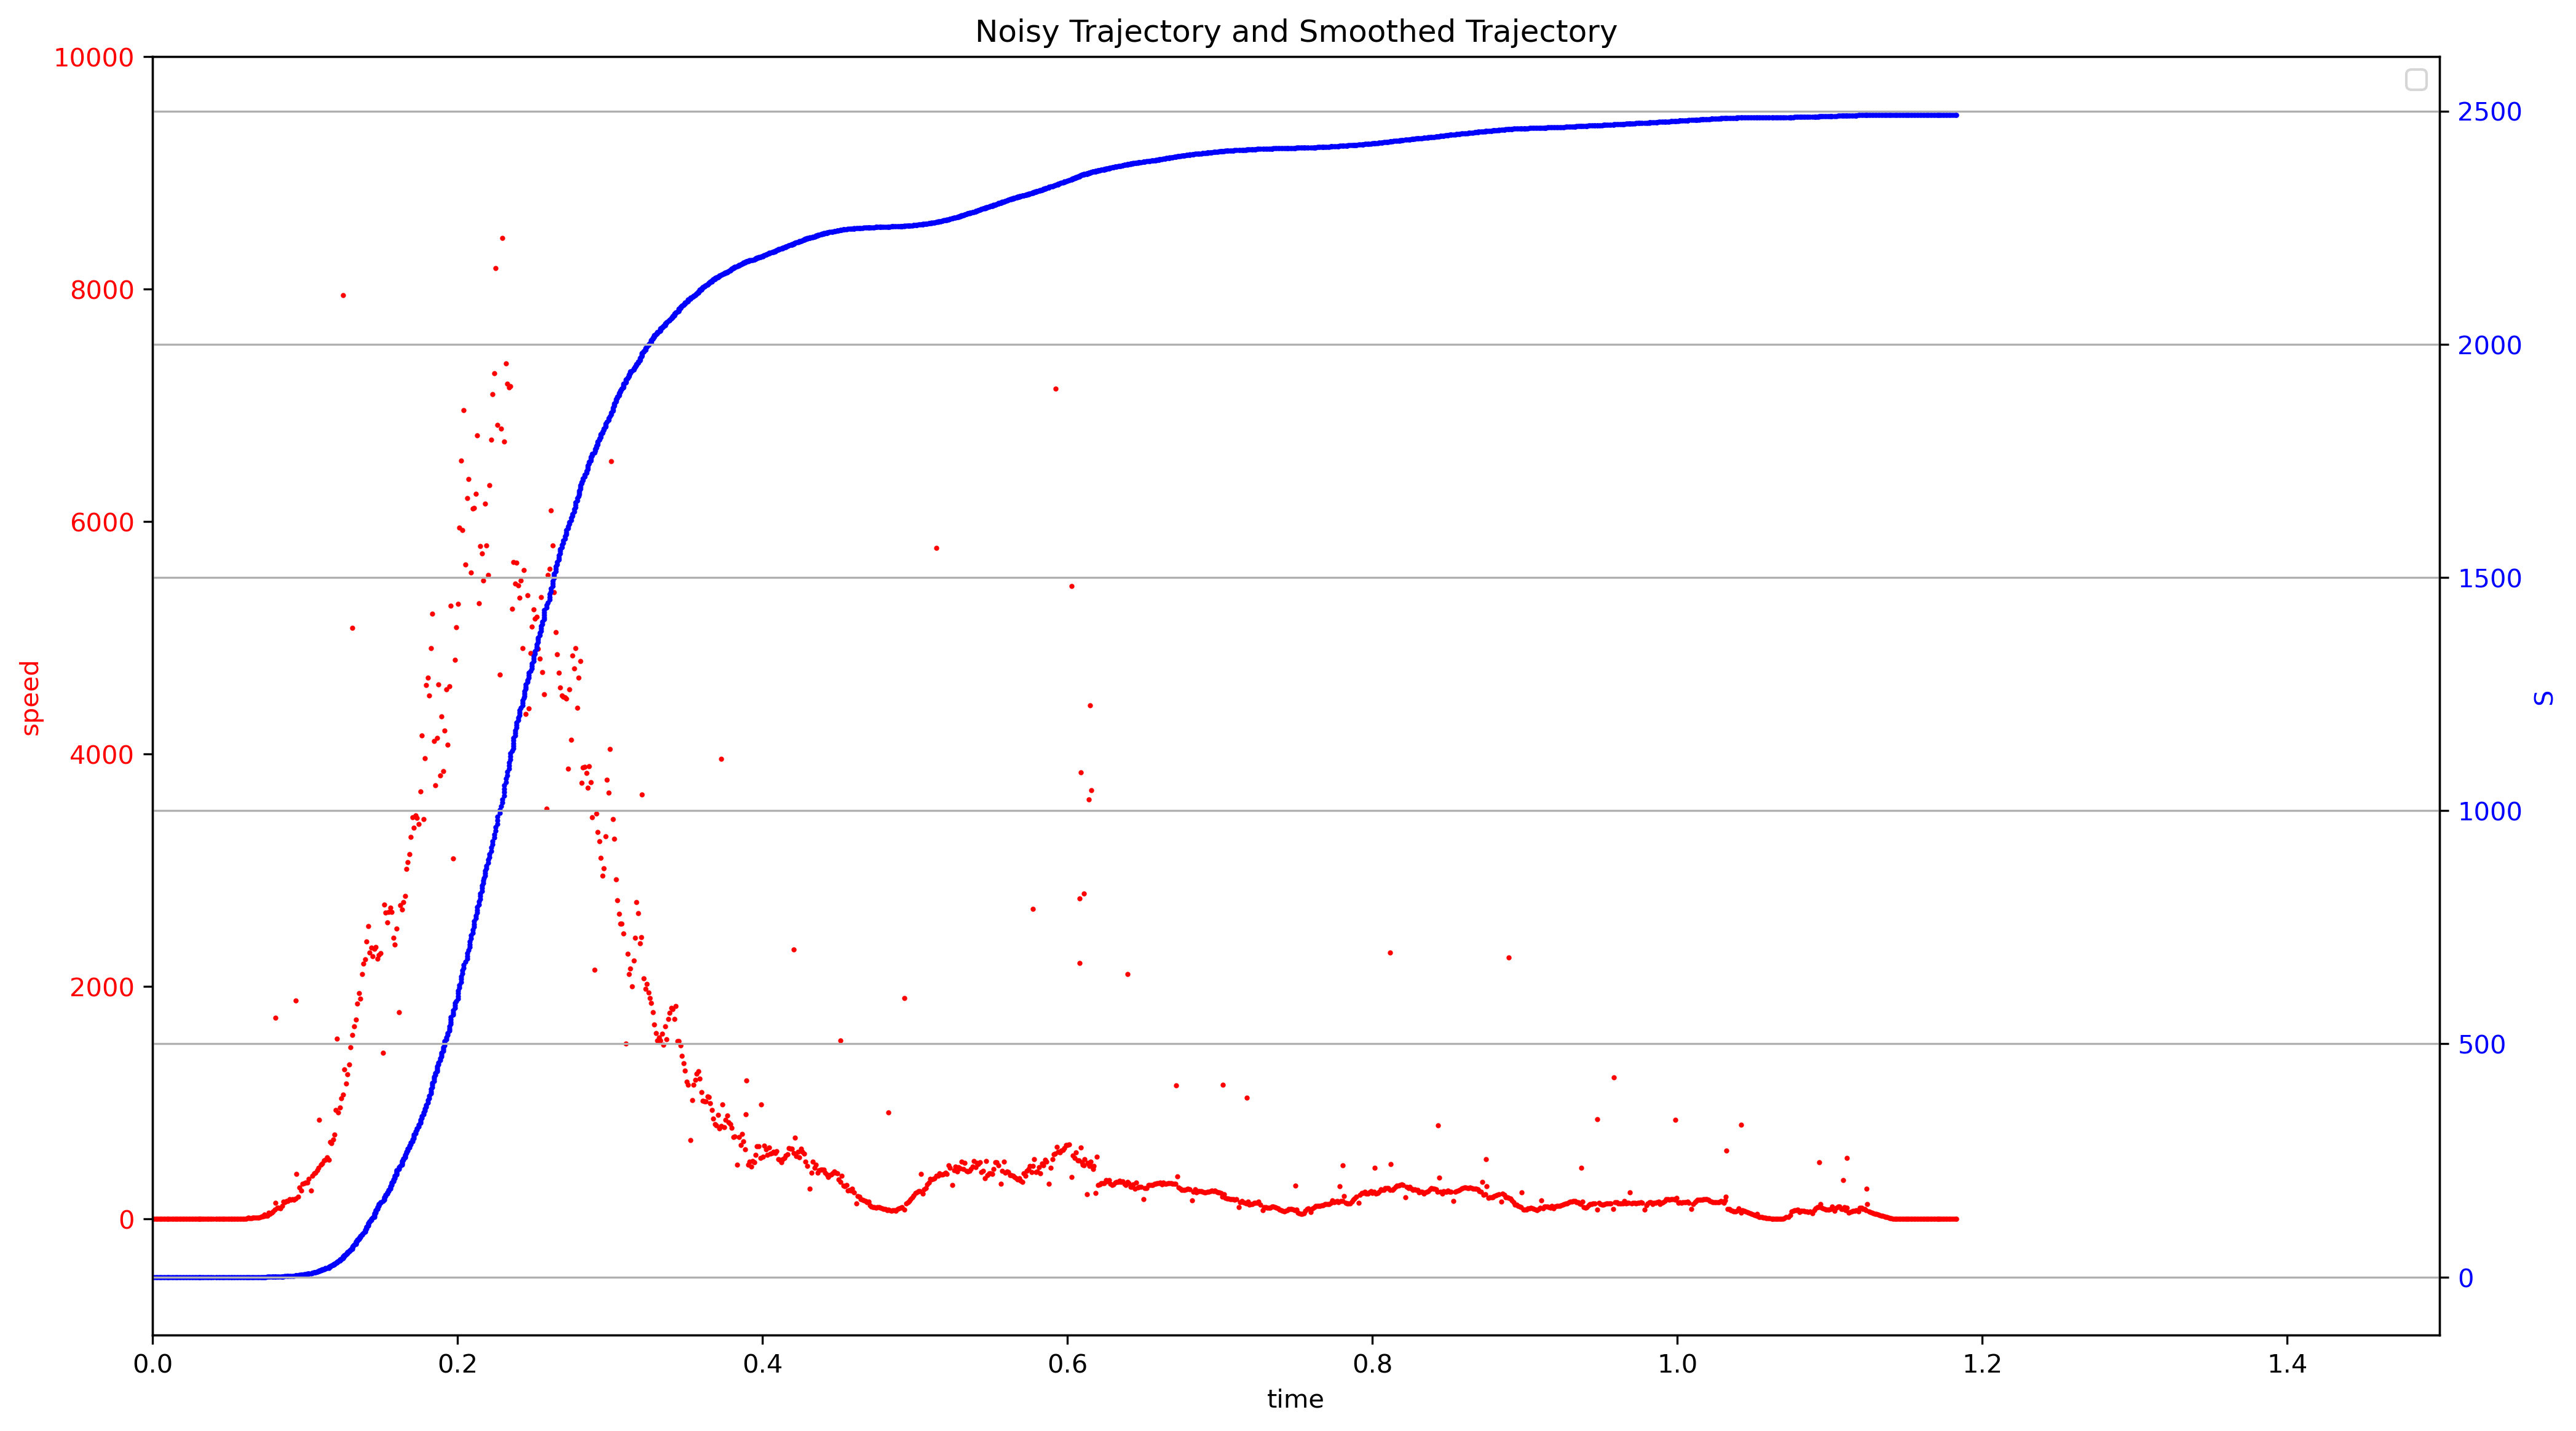

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


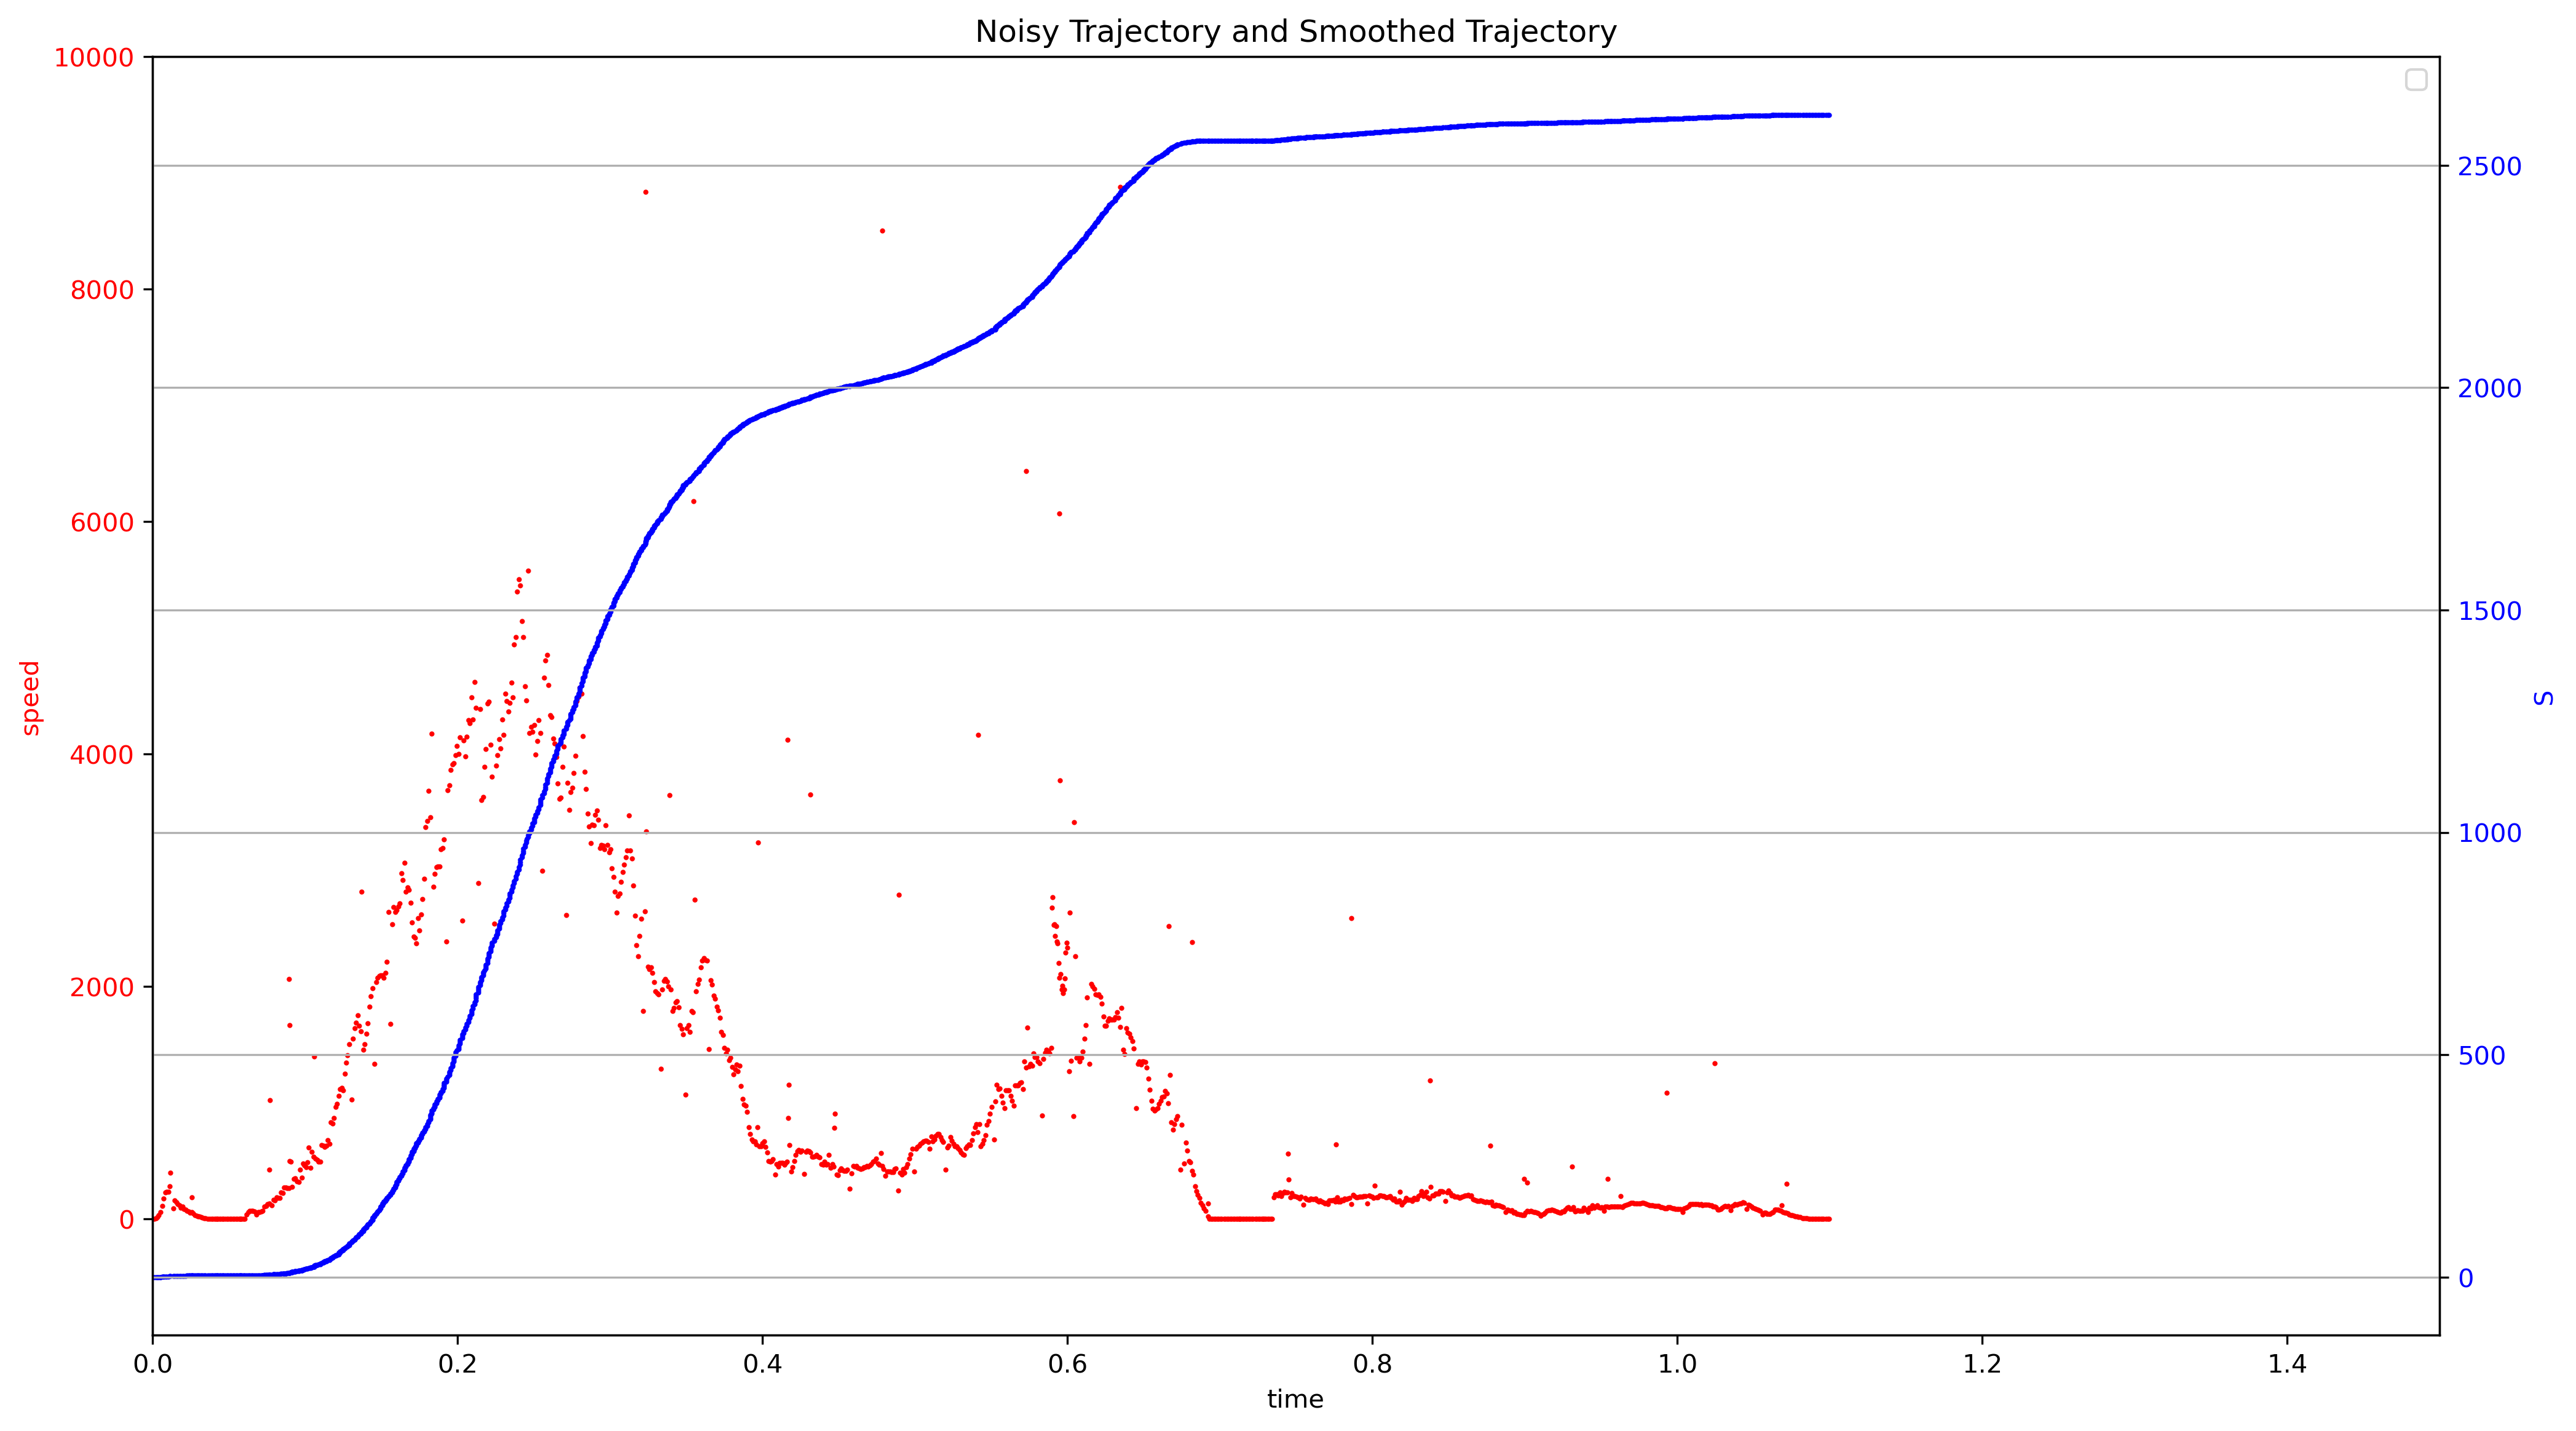

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


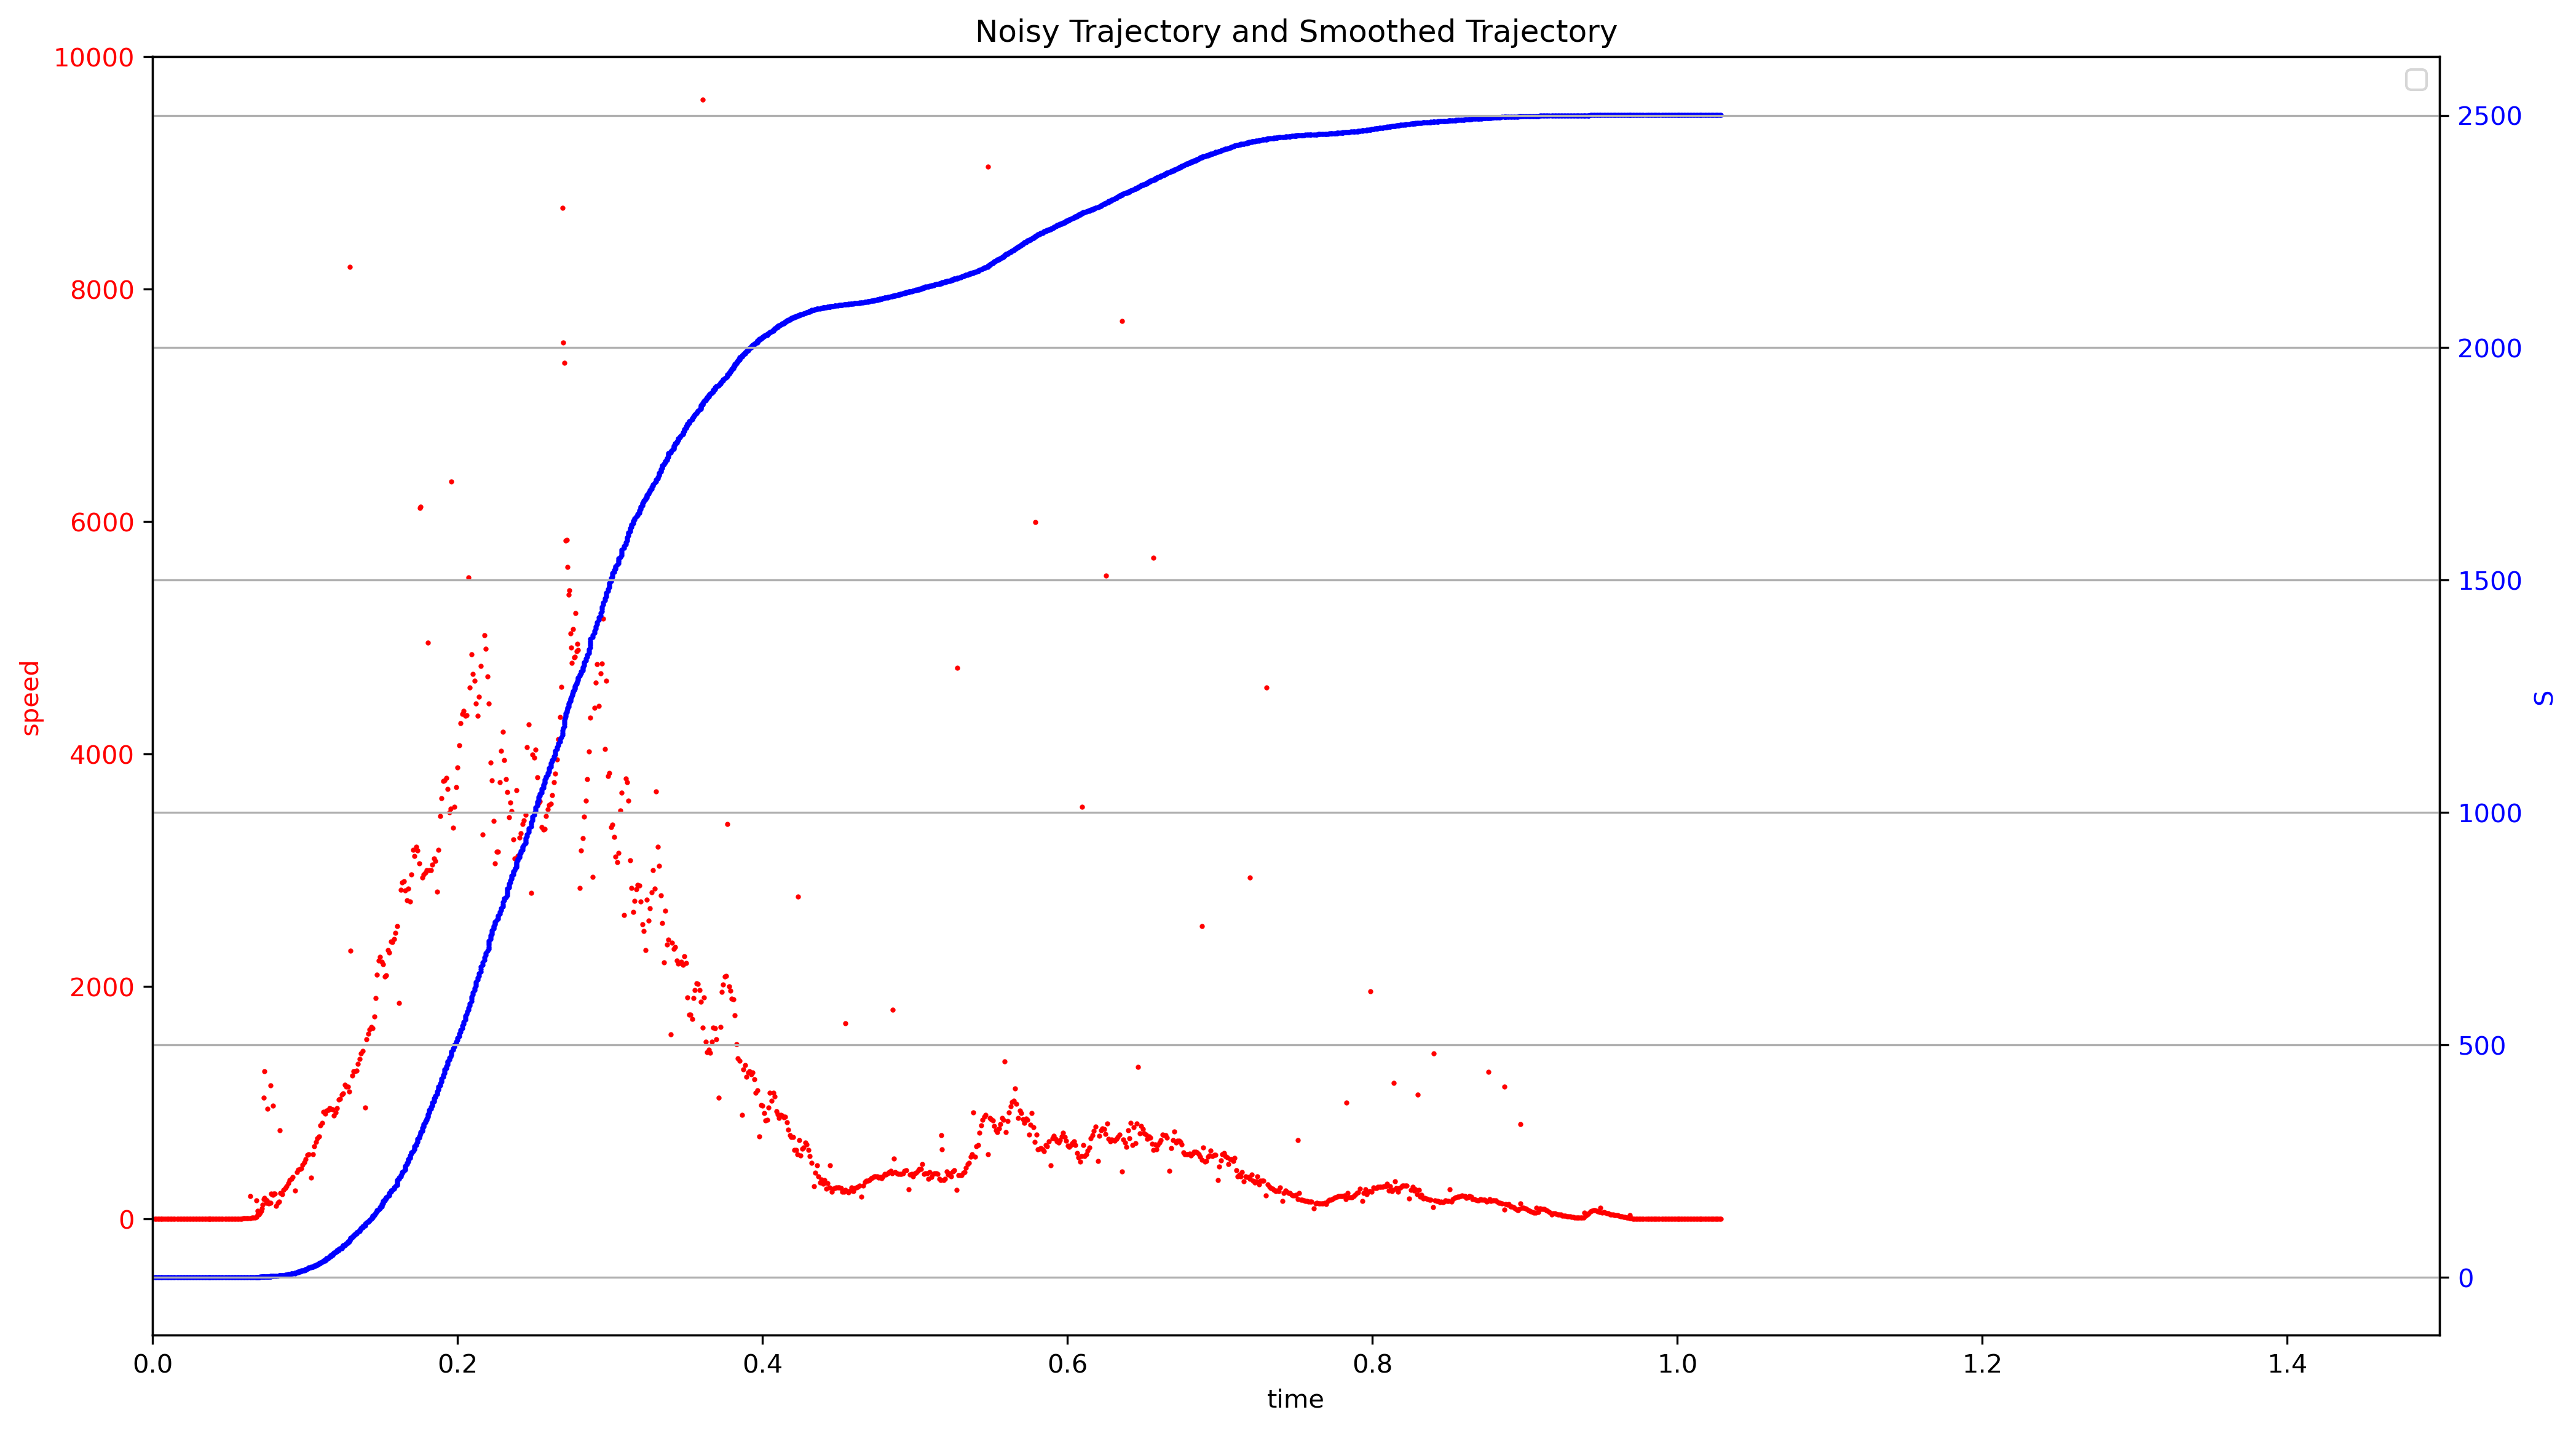

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


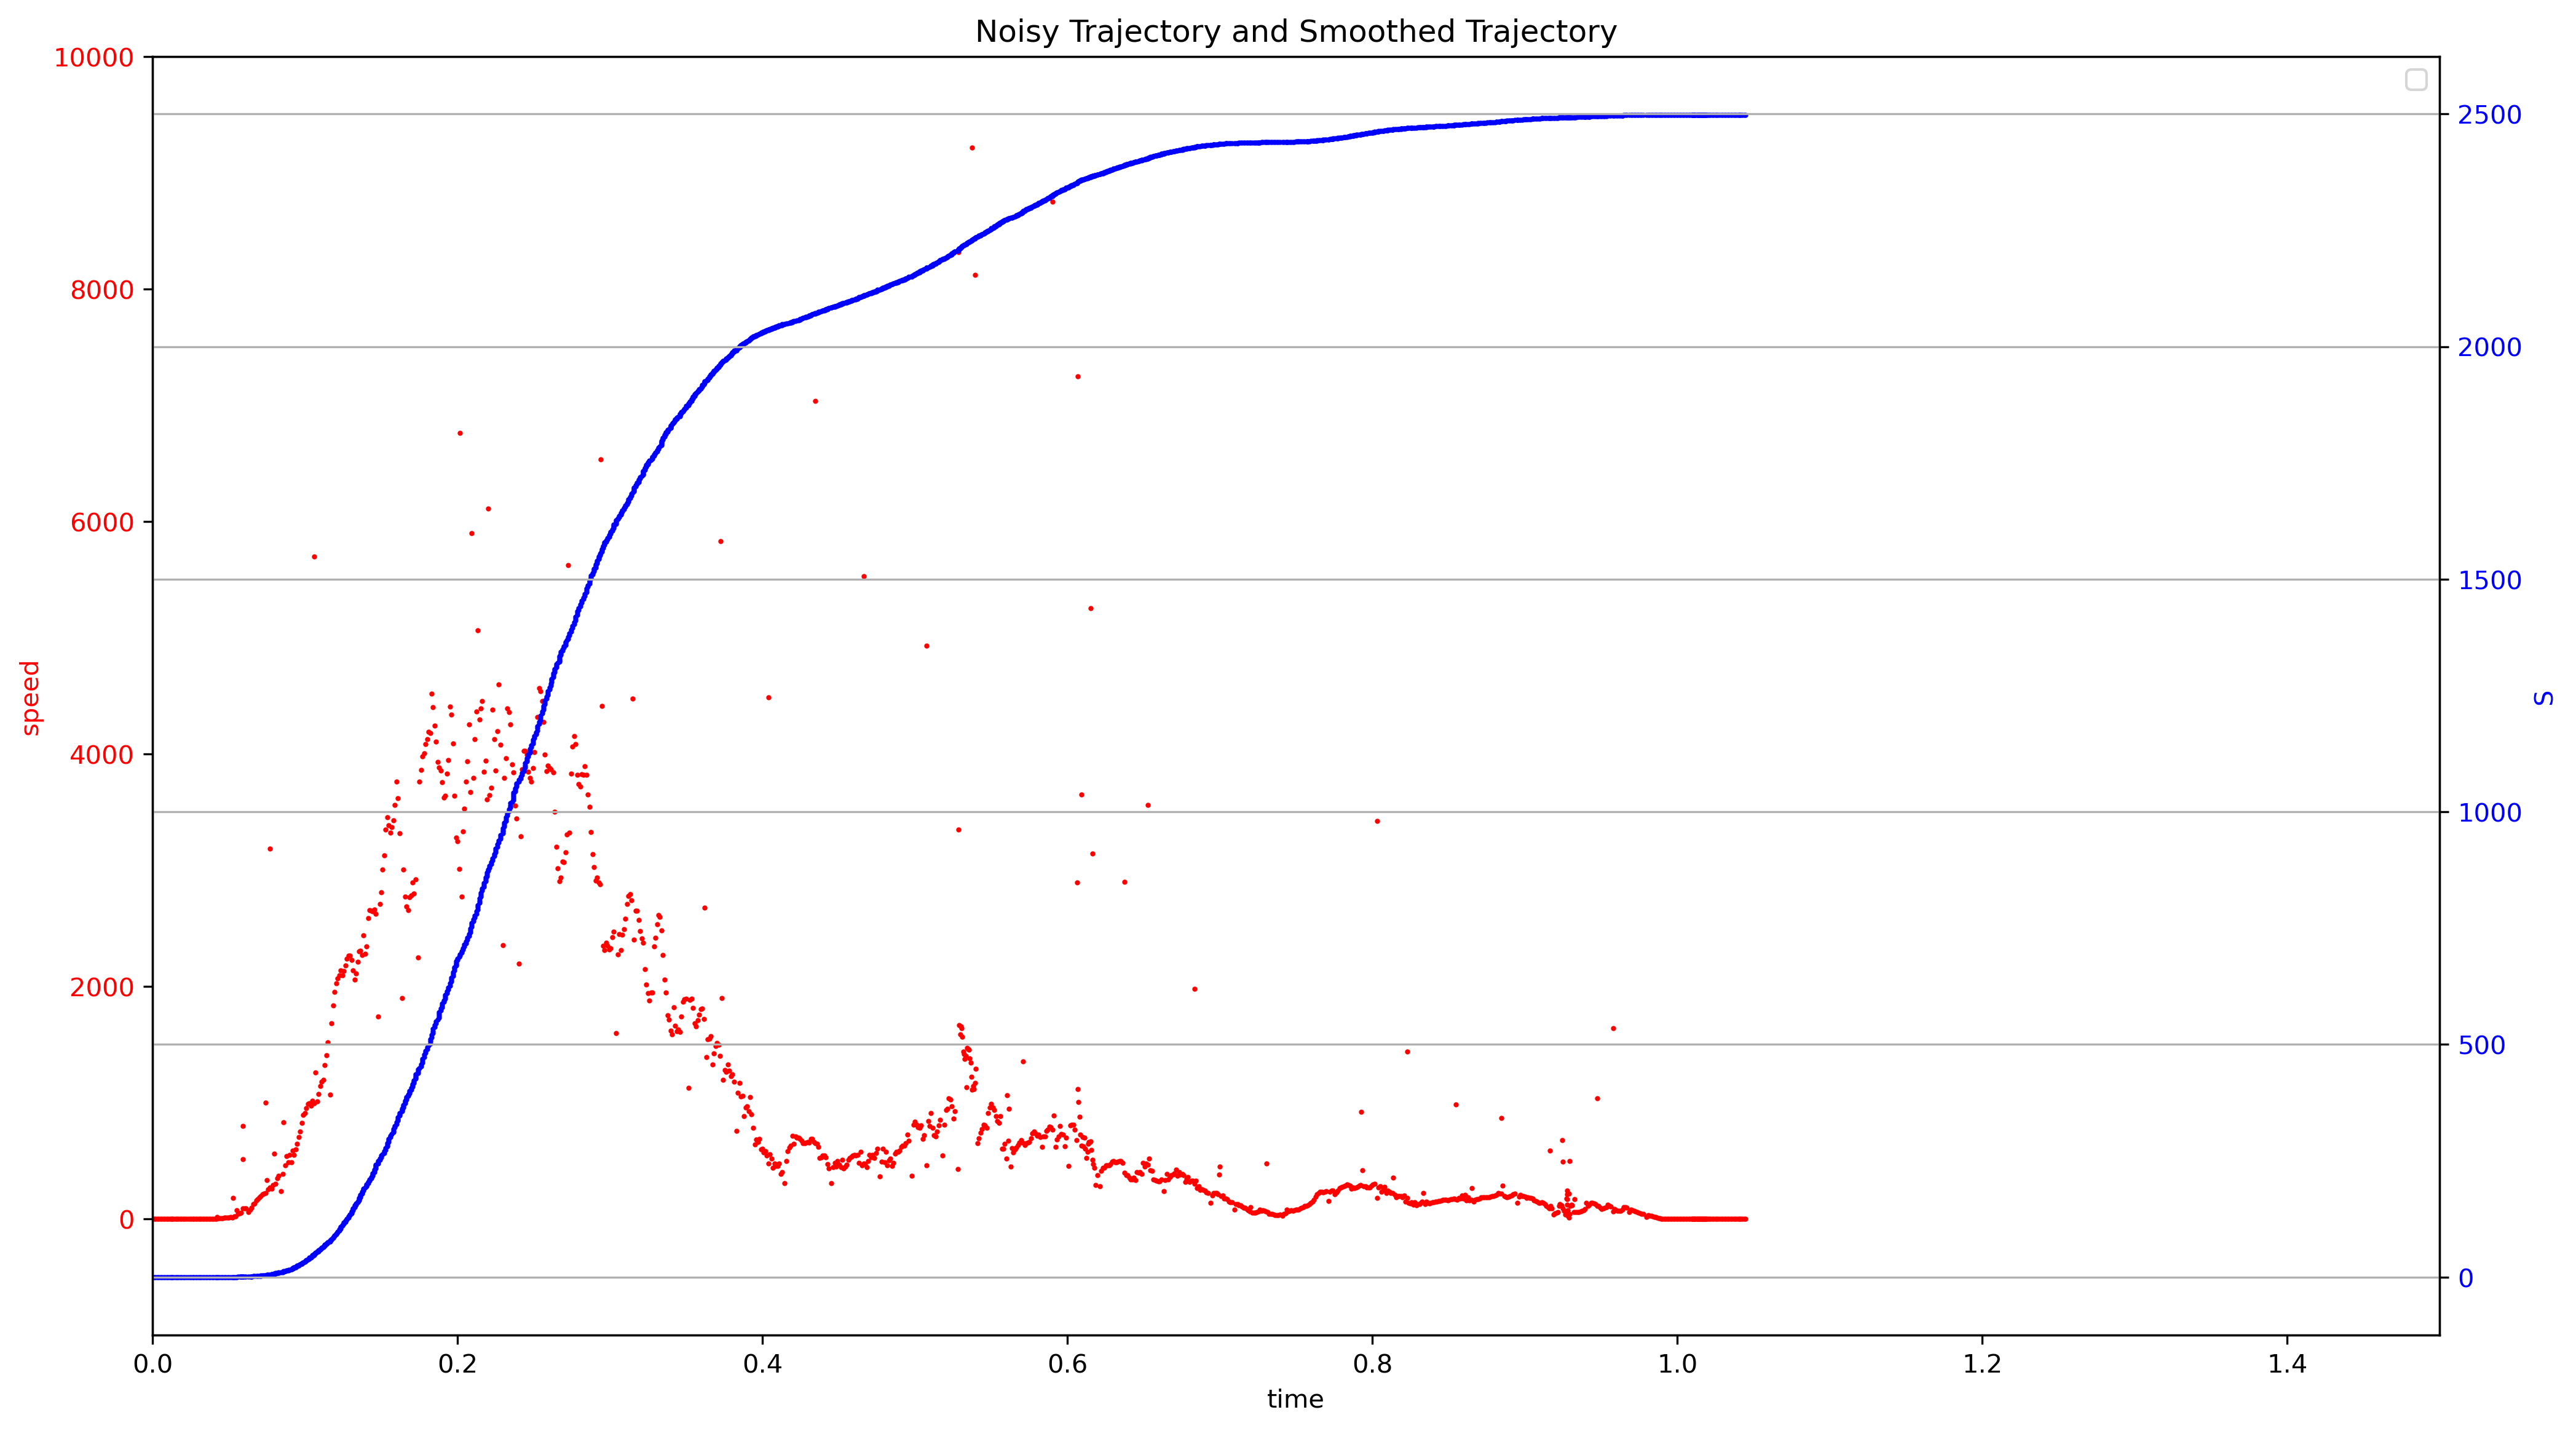

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


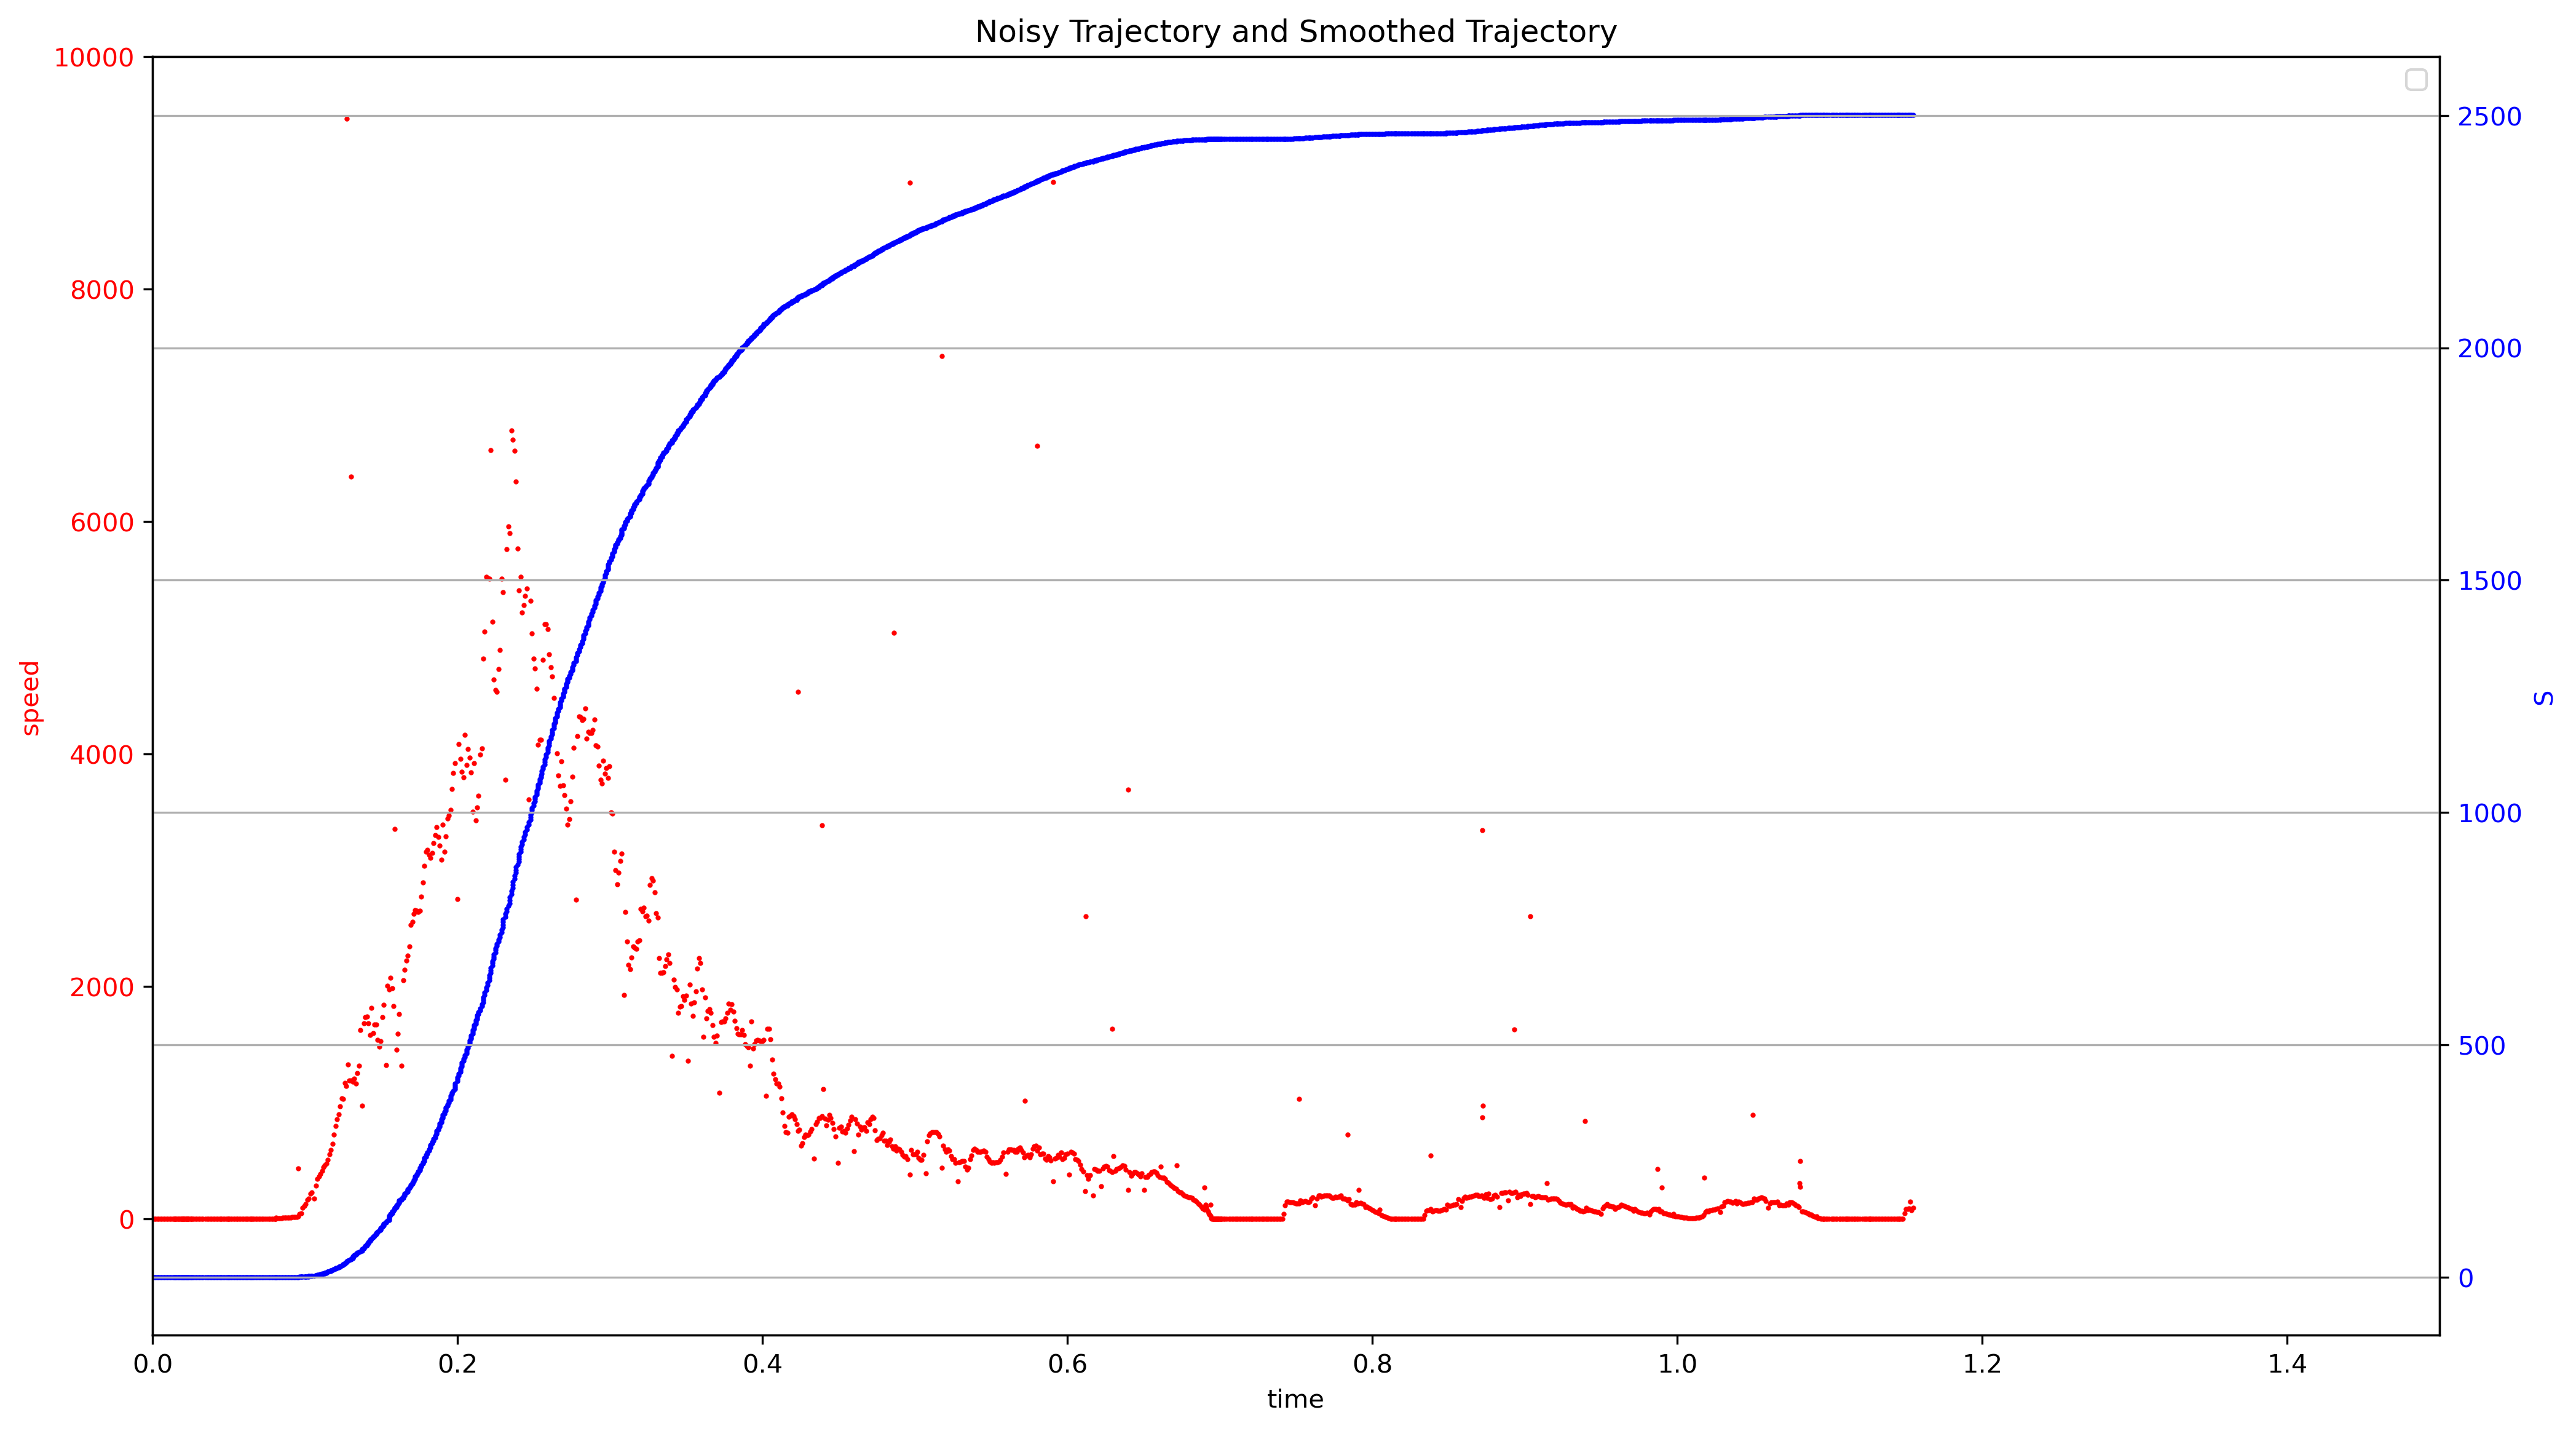

In [109]:
#已知T，S，S_smooth
#求S的一阶导数
def calculate_velocity(time, distance):
    """
    计算速度
    :param time: 时间列表（单位：秒）
    :param distance: 距离列表（单位：米）
    :return: 速度列表（单位：米/秒）
    """
    velocities = [0,]
    for i in range(len(time) - 1):
         velocities.append((distance[i+1]-distance[i]) / (time[i+1] - time[i]))
    return velocities
colors = [
('red', '#FF0000'),
('black', '#00FF00'),
('blue', '#0000FF'),
('green', '#000000'),
]

V_all=[]
for i in range(len(T_all)):
    V_all.append(calculate_velocity(T_all[i], S_all_smoothed[i]))

    fig, ax1 = plt.subplots()
    fig.dpi=300
    fig.set_size_inches(16, 9)
    
    # 绘制原始数据和拟合曲线
    ax1.set_xlim(0, 1.5)
    ax1.set_xlabel('time')
    ax1.set_ylabel('speed', color=colors[0][0])
    ax1.scatter(T_all[i], V_all[i], color=colors[0][0],s=1)
    ax1.tick_params(axis='y', labelcolor=colors[0][0])
    ax1.set_ylim(-1000,10000)
    
    ax2 = ax1.twinx()  # 创建共享X轴的第二个坐标轴

    ax2.set_ylabel('S', color=colors[2][0])
    ax2.scatter(T_all[i], S_all_smoothed[i], color=colors[2][0],s=1)
    # 输出速度列表
    
    ax2.tick_params(axis='y', labelcolor=colors[2][0])
    
    plt.title('Noisy Trajectory and Smoothed Trajectory')

    plt.legend()
    plt.grid(True)
    plt.show()
